##Without AE (LSTM)

In [ ]:
import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import holidays
import json
import copy
import numpy as np
import random
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
import pandas as pd
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
  #  plt.imshow(cm, interpolation='nearest', cmap=cmap)
   # plt.title(title)
    #plt.colorbar()
    #tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)


    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



    print(cm)
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)


def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))
class MCD_AE(nn.Module):

    def __init__(self, n_features, output_length, batch_size):
        super(MCD_AE, self).__init__()

        self.batch_size = batch_size  # user-defined

        self.hidden_size_1 = 128
        self.hidden_size_2 = 64
        self.stacked_layers = 2
        self.dropout_probability = 0.2  # arbitrary value (the paper suggests that performance is generally stable across all ranges)


        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)

        output, _ = self.lstm1(x, hidden)

        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :]  # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state

    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

###Prepare Labels
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

# %%
os.makedirs('csv', exist_ok=True)

# %%
selected_columns = ['index', 'name',  'value']



df_label = pd.read_csv(CSV_URL)

#name='F-7'
MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']






SMAP=pd.Series(SMAP)
MSL=pd.Series(MSL)
seed=42
torch.backends.cudnn.determinestic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
#pdb.set_trace()
avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=0
training_truth_df=pd.DataFrame()

for name in SMAP:

        label_row = df_label[df_label.chan_id == name]
    # pdb.set_trace()

        labels = label_row.anomaly_sequences[im]
        labels = eval(labels)

        true_indices_grouped = [list(range(e[0], e[1] + 1)) for e in labels]
        true_indices_flat = set([i for group in true_indices_grouped for i in group])

        appended_data = []

        labels = true_indices_flat

    # for i in range(len(labels)):
    #    anom=labels[i]
    # start=anom[0]
    # end=anom[1]

        index = list(labels)

    # timestamp = index * 86400 + 1022819200

        anomalies = pd.DataFrame({'value': 1, 'index': index})
    #     appended_data.append(anomalies)

        label_data = anomalies

    # label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
    # label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data['name'] = name
    # label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
    # label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)


        #label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        #label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        #label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        #label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'name']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        #plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 30

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)

        #sns.displot(data=y_test,  kind="hist", bins=100, aspect=1.5)
      #  plt.show()
       # pdb.set_trace()

        #f = Fitter(y_train,
         #          distributions=['gamma',
          #                        'lognorm',
           #                       "beta",
            #                      "burr",
             #                     "norm",'cauchy', 'chi2', 'expon', 'exponpow', 'powerlaw', 'rayleigh', 'uniform'])
        #f.fit()
        #f.summary()
        #pdb.set_trace()
        n_features = scaled_array.shape[-1]
        sequence_length = 40
        output_length = 1

        batch_size = 64
        n_epochs = 10
        learning_rate = 0.01

        bayesian_lstm = MCD_AE(n_features=n_features,
                                     output_length=output_length,
                                     batch_size=batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)
        bayesian_lstm.train()

        for e in range(1, n_epochs + 1):
            for b in range(0, len(X_train), batch_size):
                features = X_train[b:b + batch_size, :, :]
                target = y_train[b:b + batch_size]

                X_batch = torch.tensor(features, dtype=torch.float32)
                y_batch = torch.tensor(target, dtype=torch.float32)
               # pdb.set_trace()

                output = bayesian_lstm(X_batch)
                loss = criterion(output.view(-1), y_batch)


                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if e % 10 == 0:
                print('epoch', e, 'loss: ', loss.item())
                offset = sequence_length

        training_df = pd.DataFrame()
       # training_df['date'] = resample_df['date'].iloc[offset:n_train + offset:1]
        training_df['index'] = resample_df['index'].iloc[offset:n_train + offset:1]
        training_predictions = bayesian_lstm.predict(X_train)



        training_df['value'] = inverse_transform(training_predictions)
        training_df['source'] = 'Training Prediction'


        #training_truth_df['date'] = training_df['date']
        training_truth_df['index'] = training_df['index']
        training_truth_df['value'] = resample_df['value'].iloc[
                                     offset:n_train + offset:1]
        training_truth_df['source'] = 'True Values'

        testing_df = pd.DataFrame()
        #testing_df['date'] = resample_df_test['date'].iloc[offset:n_test + offset:1]
        testing_df['index'] = resample_df_test['index'].iloc[offset:n_test + offset:1]

        testing_predictions = bayesian_lstm.predict(X_test)

        testing_df['value'] = inverse_transform(testing_predictions)
        testing_df['source'] = 'Test Prediction'

        testing_truth_df = pd.DataFrame()
        #testing_truth_df['date'] = testing_df['date']
        testing_truth_df['index'] = testing_df['index']

        testing_truth_df['value'] = resample_df_test['value'].iloc[offset:n_test + offset:1]
        testing_truth_df['source'] = 'True Values'


        evaluation = pd.concat([training_df,
                                testing_df,
                                training_truth_df,
                                testing_truth_df
                                ], axis=0)

        fig = px.line(evaluation,
                             x="index",
                              y="value",
                              color="source")
        #fig.show()

        n_experiments = 2
        test_uncertainty_df = pd.DataFrame()
        #test_uncertainty_df['date'] = testing_df['date']
        test_uncertainty_df['index'] = testing_df['index']

        for i in range(n_experiments):
            experiment_predictions = bayesian_lstm.predict(X_test)

            test_uncertainty_df['value_{}'.format(i)] = inverse_transform(experiment_predictions)

        log_energy_consumption_df = test_uncertainty_df.filter(like='value', axis=1)
        test_uncertainty_df['value_mean'] = log_energy_consumption_df.mean(axis=1)
        test_uncertainty_df['value_std'] = log_energy_consumption_df.std(axis=1)


        test_uncertainty1 = test_uncertainty_df['value_mean']

        #########################Adaptive Smoothing

        #   pdb.set_trace()
        Threshold = 10
        gamma = 0.1
        betta = 0.1
        test_uncertainty2 = []
        ###########
        for jj in range(len(test_uncertainty1) - 2):
            test_uncertaintyy = (1 / (1 + gamma + betta)) * (
                        test_uncertainty1.iloc[jj] + gamma * test_uncertainty1.iloc[jj + 1] + betta *
                        test_uncertainty1.iloc[jj + 2])
            test_uncertainty2.append(test_uncertaintyy)
        test_uncertainty2 = pd.DataFrame(test_uncertainty2)

        test_uncertainty2.columns = ["value_mean"]


        test_uncertainty_df["value_mean"] = test_uncertainty2["value_mean"]

        ########################################################


        test_uncertainty_df = test_uncertainty_df[['index',  'value_mean', 'value_std']]
        test_uncertainty_df['lower_bound'] = test_uncertainty_df['value_mean'] - 3* test_uncertainty_df['value_std']
        test_uncertainty_df['upper_bound'] = test_uncertainty_df['value_mean'] + 3 * test_uncertainty_df['value_std']
        import plotly.graph_objects as go

        test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
        # test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2016-05-01', '2016-05-09')]
        truth_uncertainty_plot_df = testing_truth_df.copy(deep=True)
        # truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_truth_df['date'].between('2016-05-01', '2016-05-09')]

        upper_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['upper_bound'],
          mode='lines',
         fill=None,
         name='99% Upper Confidence Bound'
         )
        lower_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['lower_bound'],
          mode='lines',
          fill='tonexty',
         name= '99% Lower Confidence Bound',
         fillcolor='rgba(255, 211, 0, 0.1)',
         )
        real_trace = go.Scatter(
            x=truth_uncertainty_plot_df['index'],
            y=truth_uncertainty_plot_df['value'],
            mode='lines',
            fill=None,
            name='Real Values'
        )

        labels = go.Scatter(
           x=label_data['index'],
          y=label_data['value'],
         mode='lines',
         fill='tonexty' ,
         name='labels'
         )
        data = [upper_trace, lower_trace, real_trace]

        fig = go.Figure(data=data)
        fig.update_layout(title='Uncertainty MCDropout Test Data',
                            xaxis_title='index',
                            yaxis_title='value',
         legend_font_size=14,
                          )
        #fig.show()
        bounds_df = pd.DataFrame()

        # Using 99% confidence bounds
        bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
        bounds_df['prediction'] = test_uncertainty_plot_df['value_mean']
        bounds_df['real_value'] = truth_uncertainty_plot_df['value']
        bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

        bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                                  (bounds_df['real_value'] <= bounds_df['upper_bound']))

        print("Proportion of points contained within 99% confidence interval:",
              bounds_df['contained'].mean())
        predictedanomaly = bounds_df.index[~bounds_df['contained']]






        realanomaly = label_data['index']

        predicter=list(range(len(test_uncertainty2)))

        a1 = pd.DataFrame(index=range(len(test_uncertainty2)),columns=range(2))
        a1.columns=['index','value']

        a2 = pd.DataFrame(index=range(len(test_uncertainty2)), columns=range(2))
        a2.columns = ['index','value']




        for i in range(len(predicter)):
            if i in predictedanomaly:
                a1.iloc[i,1]=1
            else:
                a1.iloc[i,1]=0

        for i in range(len(predicter)):
            if i in realanomaly:
                a2.iloc[i,1] = 1
            else:
                a2.iloc[i, 1] = 0

        y_real=a2.value
        y_real=y_real.astype(int)
        y_predi=a1.value
        y_predi=y_predi.astype(int)


        cm = confusion_matrix(y_true=y_real, y_pred=y_predi)
        cm_plot_labels = ['no_anomaly', 'had_anomaly']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

        # tp = len([np.where(predicteddanomaly == x)[0] for x in realanomaly])
        #fp = len(predicteddanomaly) - tp
        #fn = 0
        #tn = len(truth_uncertainty_plot_df) - tp - fp - fn

        tp=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tn=cm[1][1]

        precision1 = tp / (tp + fp)
        recall1 = tp / (tp + fn)
        Accuracy1 = (tp + tn) / len(truth_uncertainty_plot_df)
        F11 = 2 / ((1 / precision1) + (1 / recall1))
        print('precision', precision1, 'Signal', name)
        print('recall', recall1, 'Signal', name)
        print('Accuracy', Accuracy1, 'Signal', name)
        print('F1', F11, 'Signal', name)
        precision.append(precision1)
        F1.append(F11)
        Accuracy.append(Accuracy1)
        recall.append(recall1)

        im=im+1

        #matched_indices = list(i_anom_predicted & true_indices_flat)


recall_final=mean(recall)
precision_final=mean(precision)
F1_final=mean(F1)
Accuracy_final=mean(Accuracy)
#cm = confusion_matrix(y_true=test_labels, y_pred=predicteddanomaly)

################################################################################

# %%

## New Test Bayesian LSTM AE
print('precision_final_LSTM', precision_final)
print('recall_final_LSTM', recall_final)
print('Accuracy_final_LSTM',Accuracy_final)
print('F1_final_LSTM', F1_final)


epoch 10 loss:  0.022840972989797592


ValueError: ignored

In [ ]:
import math
F1t = [0 if math.isnan(x) else x for x in F1]
F1y = [item for item in F1 if not(math.isnan(item)) == True]
F1yy=[item for item in F1y if item> 0]
F1_final=mean(F1yy)
Accuracy_final=mean(Accuracy)
Recall_final=mean(recall)
Precisiont = [0 if math.isnan(x) else x for x in precision]
Precisiony = [item for item in precision if not(math.isnan(item)) == True]
Precisionyy=[item for item in Precisiony if item> 0]
Precision_final=mean(Precisionyy)
print('Precision_final', Precision_final)
print('Recall_final', Recall_final)
print('Accuracy_final',Accuracy_final)
print('F1_final',F1_final)

#cm = confusion_matrix(y_true=test_labels, y_pred=predicteddanomaly)

Precision_final 0.2880509010996978
Recall_final 0.527818816469805
Accuracy_final 0.27842356420896275
F1_final 0.3670183061667136


##With AE

In [ ]:
import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import holidays
import json
import copy
import numpy as np
import torch
import random
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
import pandas as pd
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
seed=42
torch.backends.cudnn.determinestic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       
  
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)


def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))
class MCD_AE(nn.Module):

    def __init__(self, n_features, output_length, batch_size):
        super(MCD_AE, self).__init__()

        self.batch_size = batch_size  # user-defined

        self.hidden_size_1 = 80
        self.hidden_size_2 = 32
        self.hidden_size_3= 16
        self.hidden_size_4 = 32
        self.stacked_layers = 2
        self.dropout_probability = 0.5  # arbitrary value (the paper suggests that performance is generally stable across all ranges)


        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm3 = nn.LSTM(self.hidden_size_2,
                             self.hidden_size_3,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm4 = nn.LSTM(self.hidden_size_3,
                             self.hidden_size_4,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_4, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)

        output, _ = self.lstm1(x, hidden)

        #output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        state = self.init_hidden3(batch_size)
        output, state = self.lstm3(output, state)
        state = self.init_hidden4(batch_size)
        output, state = self.lstm4(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :]  # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state
    def init_hidden3(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_3))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_3))
        return hidden_state, cell_state
    def init_hidden4(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_4))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_4))
        return hidden_state, cell_state
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()
###Prepare Labels
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

# %%
os.makedirs('csv', exist_ok=True)

# %%
selected_columns = ['index', 'name',  'value']



df_label = pd.read_csv(CSV_URL)

#name='F-7'
MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']






SMAP=pd.Series(SMAP)
MSL=pd.Series(MSL)

#pdb.set_trace()
avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=0
training_truth_df=pd.DataFrame()

for name in SMAP:

        label_row = df_label[df_label.chan_id == name]
    # pdb.set_trace()

        labels = label_row.anomaly_sequences[im]
        labels = eval(labels)

        true_indices_grouped = [list(range(e[0], e[1] + 1)) for e in labels]
        true_indices_flat = set([i for group in true_indices_grouped for i in group])

        appended_data = []

        labels = true_indices_flat

    # for i in range(len(labels)):
    #    anom=labels[i]
    # start=anom[0]
    # end=anom[1]

        index = list(labels)

    # timestamp = index * 86400 + 1022819200

        anomalies = pd.DataFrame({'value': 1, 'index': index})
    #     appended_data.append(anomalies)

        label_data = anomalies

    # label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
    # label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data['name'] = name
    # label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
    # label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)


        #label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        #label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        #label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        #label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'name']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        #plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 10

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)

        #sns.displot(data=y_test,  kind="hist", bins=100, aspect=1.5)
      #  plt.show()
       # pdb.set_trace()

        #f = Fitter(y_train,
         #          distributions=['gamma',
          #                        'lognorm',
           #                       "beta",
            #                      "burr",
             #                     "norm",'cauchy', 'chi2', 'expon', 'exponpow', 'powerlaw', 'rayleigh', 'uniform'])
        #f.fit()
        #f.summary()
        #pdb.set_trace()
        n_features = scaled_array.shape[-1]
        sequence_length = 10
        output_length = 1

        batch_size = 64
        n_epochs = 10
        learning_rate = 0.01

        bayesian_lstm = MCD_AE(n_features=n_features,
                                     output_length=output_length,
                                     batch_size=batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)
        bayesian_lstm.train()

        for e in range(1, n_epochs + 1):
            for b in range(0, len(X_train), batch_size):
                features = X_train[b:b + batch_size, :, :]
                target = y_train[b:b + batch_size]

                X_batch = torch.tensor(features, dtype=torch.float32)
                y_batch = torch.tensor(target, dtype=torch.float32)
               # pdb.set_trace()

                output = bayesian_lstm(X_batch)
                loss = criterion(output.view(-1), y_batch)


                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if e % 10 == 0:
                print('epoch', e, 'loss: ', loss.item())
                offset = sequence_length

        training_df = pd.DataFrame()
       # training_df['date'] = resample_df['date'].iloc[offset:n_train + offset:1]
        training_df['index'] = resample_df['index'].iloc[offset:n_train + offset:1]
        training_predictions = bayesian_lstm.predict(X_train)


        training_df['value'] = inverse_transform(training_predictions)
        training_df['source'] = 'Training Prediction'


        #training_truth_df['date'] = training_df['date']
        training_truth_df['index'] = training_df['index']
        training_truth_df['value'] = resample_df['value'].iloc[
                                     offset:n_train + offset:1]
        training_truth_df['source'] = 'True Values'

        testing_df = pd.DataFrame()
        #testing_df['date'] = resample_df_test['date'].iloc[offset:n_test + offset:1]
        testing_df['index'] = resample_df_test['index'].iloc[offset:n_test + offset:1]

        testing_predictions = bayesian_lstm.predict(X_test)

        testing_df['value'] = inverse_transform(testing_predictions)
        testing_df['source'] = 'Test Prediction'

        testing_truth_df = pd.DataFrame()
        #testing_truth_df['date'] = testing_df['date']
        testing_truth_df['index'] = testing_df['index']

        testing_truth_df['value'] = resample_df_test['value'].iloc[offset:n_test + offset:1]
        testing_truth_df['source'] = 'True Values'


        evaluation = pd.concat([training_df,
                                testing_df,
                                training_truth_df,
                                testing_truth_df
                                ], axis=0)

        fig = px.line(evaluation,
                             x="index",
                              y="value",
                              color="source")
        #fig.show()

        n_experiments = 2
        test_uncertainty_df = pd.DataFrame()
        #test_uncertainty_df['date'] = testing_df['date']
        test_uncertainty_df['index'] = testing_df['index']

        for i in range(n_experiments):
            experiment_predictions = bayesian_lstm.predict(X_test)

            test_uncertainty_df['value_{}'.format(i)] = inverse_transform(experiment_predictions)

        log_energy_consumption_df = test_uncertainty_df.filter(like='value', axis=1)
        test_uncertainty_df['value_mean'] = log_energy_consumption_df.mean(axis=1)
        test_uncertainty_df['value_std'] = log_energy_consumption_df.std(axis=1)


        test_uncertainty1 = test_uncertainty_df['value_mean']

        #########################Adaptive Smoothing

        #   pdb.set_trace()
        Threshold = 10
        gamma = 0.1
        betta = 0.1
        test_uncertainty2 = []
        ###########
        for jj in range(len(test_uncertainty1) - 2):
            test_uncertaintyy = (1 / (1 + gamma + betta)) * (
                        test_uncertainty1.iloc[jj] + gamma * test_uncertainty1.iloc[jj + 1] + betta *
                        test_uncertainty1.iloc[jj + 2])
            test_uncertainty2.append(test_uncertaintyy)
        test_uncertainty2 = pd.DataFrame(test_uncertainty2)

        test_uncertainty2.columns = ["value_mean"]


        test_uncertainty_df["value_mean"] = test_uncertainty2["value_mean"]

        ########################################################


        test_uncertainty_df = test_uncertainty_df[['index',  'value_mean', 'value_std']]
        test_uncertainty_df['lower_bound'] = test_uncertainty_df['value_mean'] - 3* test_uncertainty_df['value_std']
        test_uncertainty_df['upper_bound'] = test_uncertainty_df['value_mean'] + 3 * test_uncertainty_df['value_std']
        import plotly.graph_objects as go

        test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
        # test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2016-05-01', '2016-05-09')]
        truth_uncertainty_plot_df = testing_truth_df.copy(deep=True)
        # truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_truth_df['date'].between('2016-05-01', '2016-05-09')]

        upper_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['upper_bound'],
          mode='lines',
         fill=None,
         name='99% Upper Confidence Bound'
         )
        lower_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['lower_bound'],
          mode='lines',
          fill='tonexty',
         name= '99% Lower Confidence Bound',
         fillcolor='rgba(255, 211, 0, 0.1)',
         )
        real_trace = go.Scatter(
            x=truth_uncertainty_plot_df['index'],
            y=truth_uncertainty_plot_df['value'],
            mode='lines',
            fill=None,
            name='Real Values'
        )

        labels = go.Scatter(
           x=label_data['index'],
          y=label_data['value'],
         mode='lines',
         fill='tonexty' ,
         name='labels'
         )
        data = [upper_trace, lower_trace, real_trace]

        fig = go.Figure(data=data)
        fig.update_layout(title='Uncertainty MCDropout Test Data',
                            xaxis_title='index',
                            yaxis_title='value',
         legend_font_size=14,
                          )
        #fig.show()
        bounds_df = pd.DataFrame()

        # Using 99% confidence bounds
        bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
        bounds_df['prediction'] = test_uncertainty_plot_df['value_mean']
        bounds_df['real_value'] = truth_uncertainty_plot_df['value']
        bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

        bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                                  (bounds_df['real_value'] <= bounds_df['upper_bound']))

        print("Proportion of points contained within 99% confidence interval:",
              bounds_df['contained'].mean())
        predictedanomaly = bounds_df.index[~bounds_df['contained']]






        realanomaly = label_data['index']

        predicter=list(range(len(test_uncertainty2)))

        a1 = pd.DataFrame(index=range(len(test_uncertainty2)),columns=range(2))
        a1.columns=['index','value']

        a2 = pd.DataFrame(index=range(len(test_uncertainty2)), columns=range(2))
        a2.columns = ['index','value']




        for i in range(len(predicter)):
            if i in predictedanomaly:
                a1.iloc[i,1]=1
            else:
                a1.iloc[i,1]=0

        for i in range(len(predicter)):
            if i in realanomaly:
                a2.iloc[i,1] = 1
            else:
                a2.iloc[i, 1] = 0

        y_real=a2.value
        y_real=y_real.astype(int)
        y_predi=a1.value
        y_predi=y_predi.astype(int)


        cm = confusion_matrix(y_true=y_real, y_pred=y_predi)
        cm_plot_labels = ['no_anomaly', 'had_anomaly']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

        # tp = len([np.where(predicteddanomaly == x)[0] for x in realanomaly])
        #fp = len(predicteddanomaly) - tp
        #fn = 0
        #tn = len(truth_uncertainty_plot_df) - tp - fp - fn

        tp=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tn=cm[1][1]

        precision1 = tp / (tp + fp)
        recall1 = tp / (tp + fn)
        Accuracy1 = (tp + tn) / len(truth_uncertainty_plot_df)
        F11 = 2 / ((1 / precision1) + (1 / recall1))
        print('precision', precision1, 'Signal', name)
        print('recall', recall1, 'Signal', name)
        print('Accuracy', Accuracy1, 'Signal', name)
        print('F1', F11, 'Signal', name)
        precision.append(precision1)
        F1.append(F11)
        Accuracy.append(Accuracy1)
        recall.append(recall1)

        im=im+1

        #matched_indices = list(i_anom_predicted & true_indices_flat)


recall_final=mean(recall)
precision_final=mean(precision)
F1_final=mean(F1)
Accuracy_final=mean(Accuracy)
#cm = confusion_matrix(y_true=test_labels, y_pred=predicteddanomaly)

################################################################################

# %%

## New Test Bayesian LSTM AE

print('precision_final', precision_final)
print('recall_final', recall_final)
print('Accuracy_final',Accuracy_final)
print('F1_final', F1_final)

epoch 10 loss:  0.04620598629117012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.103708063566804
precision 0.10462412813226557 Signal P-1
recall 0.9090909090909091 Signal P-1
Accuracy 0.17422012948793408 Signal P-1
F1 0.18765203289702306 Signal P-1
epoch 10 loss:  0.11611343175172806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.007649228247507171
precision 0.007713578809489158 Signal S-1
recall 0.803030303030303 Signal S-1
Accuracy 0.06665756044256249 Signal S-1
F1 0.015280380567968864 Signal S-1
epoch 10 loss:  0.05871262773871422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6185045849988243
precision 0.6179339669834918 Signal E-1
recall 0.9373932840068299 Signal E-1
Accuracy 0.6018104867152598 Signal E-1
F1 0.744855656893043 Signal E-1
epoch 10 loss:  0.11226455122232437


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.041187514667918326
precision 0.037629879247402416 Signal E-2
recall 0.7423822714681441 Signal E-2
Accuracy 0.18458108425252287 Signal E-2
F1 0.07162902579179474 Signal E-2
epoch 10 loss:  0.025540705770254135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.009159937326744607
precision 0.0149547422274695 Signal E-3
recall 0.8837209302325582 Signal E-3
Accuracy 0.3952030854525732 Signal E-3
F1 0.029411764705882353 Signal E-3
epoch 10 loss:  0.04874749109148979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0015580057526366252
precision 0.0023508137432188066 Signal E-4
recall 0.5652173913043478 Signal E-4
Accuracy 0.33736816874400766 Signal E-4
F1 0.004682153790743743 Signal E-4
epoch 10 loss:  0.047441475093364716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6791405118300338
precision 0.6767993970606707 Signal E-5
recall 0.9559971611071683 Signal E-5
Accuracy 0.6592225977788508 Signal E-5
F1 0.7925277634772375 Signal E-5
epoch 10 loss:  0.08226527273654938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.31170084439083234
precision 0.31208951593286305 Signal E-6
recall 0.9892058596761758 Signal E-6
Accuracy 0.3141133896260555 Signal E-6
F1 0.47448224852070997 Signal E-6
epoch 10 loss:  0.10855122655630112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal E-7
recall 0.0 Signal E-7
Accuracy 0.03265060240963855 Signal E-7
F1 0.0 Signal E-7
epoch 10 loss:  0.0668410211801529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.20159586951419856
precision 0.19767000126630366 Signal E-8
recall 0.9033564814814815 Signal E-8
Accuracy 0.23668153015724008 Signal E-8
F1 0.32436363636363635 Signal E-8
epoch 10 loss:  0.03111531399190426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.07477086348287507
precision 0.07494646680942184 Signal E-9
recall 0.9444444444444444 Signal E-9
Accuracy 0.10986493005306319 Signal E-9
F1 0.13887268059283464 Signal E-9
epoch 10 loss:  0.3459163308143616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6097704532077692
precision 0.608615836494921 Signal E-10
recall 0.9581888246628131 Signal E-10
Accuracy 0.5977633902295468 Signal E-10
F1 0.7444053588803232 Signal E-10
epoch 10 loss:  0.26165512204170227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal E-11
recall 0.0 Signal E-11
Accuracy 0.033513640639698965 Signal E-11
F1 0.0 Signal E-11
epoch 10 loss:  0.04793991893529892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6498470948012233
precision 0.6512567891878237 Signal E-12
recall 0.9315266485998194 Signal E-12
Accuracy 0.6304398964949424 Signal E-12
F1 0.7665774606006541 Signal E-12
epoch 10 loss:  0.09055167436599731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.006720741599073001
precision 0.0068149210903873745 Signal E-13
recall 0.8382352941176471 Signal E-13
Accuracy 0.03592120509849363 Signal E-13
F1 0.013519924098671726 Signal E-13
epoch 10 loss:  8.360724557121557e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.056546929316338354
precision 0.05665457099379609 Signal A-1
recall 0.9718875502008032 Signal A-1
Accuracy 0.06431054461181923 Signal A-1
F1 0.10706780223426611 Signal A-1
epoch 10 loss:  0.03698484227061272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.10095305330038828
precision 0.08476517754868271 Signal D-1
recall 0.511520737327189 Signal D-1
Accuracy 0.38581009530533006 Signal D-1
F1 0.14543072387815265 Signal D-1
epoch 10 loss:  0.05327887460589409


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.020612269788998657
precision 0.02037010471955243 Signal P-2
recall 0.7932960893854749 Signal P-2
Accuracy 0.16233687035004268 Signal P-2
F1 0.03972027972027972 Signal P-2
epoch 10 loss:  0.012698506936430931


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7584580926559
precision 0.7549335199440168 Signal P-3
recall 0.8370577281191807 Signal P-3
Accuracy 0.6695744430036543 Signal P-3
F1 0.7938774008389138 Signal P-3
epoch 10 loss:  1.7178461320099814e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5136866627839255
precision 0.11775486827033219 Signal D-2
recall 0.116289592760181 Signal D-2
Accuracy 0.09621432731508445 Signal D-2
F1 0.11701764371087081 Signal D-2
epoch 10 loss:  0.19888408482074738


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.004519119351100811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal D-3
recall 0.0 Signal D-3
Accuracy 0.373928157589803 Signal D-3
F1 0.0 Signal D-3
epoch 10 loss:  0.28653931617736816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal D-4
recall 0.0 Signal D-4
Accuracy 0.3826066406711568 Signal D-4
F1 0.0 Signal D-4
epoch 10 loss:  0.06730843335390091


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.16864878542510123
precision 0.16839943524579642 Signal A-2
recall 0.9769173492181683 Signal A-2
Accuracy 0.17611336032388664 Signal A-2
F1 0.2872783008539523 Signal A-2
epoch 10 loss:  0.00978243537247181


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5310555216595485
precision 0.5322842512801299 Signal A-3
recall 0.9770747363594682 Signal A-3
Accuracy 0.5305674191580232 Signal A-3
F1 0.6891422103646212 Signal A-3
epoch 10 loss:  0.025673655793070793


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.40049566294919453
precision 0.40090486364207617 Signal A-4
recall 0.9839605181986428 Signal A-4
Accuracy 0.4026022304832714 Signal A-4
F1 0.5696937226538085 Signal A-4
epoch 10 loss:  0.08528917282819748


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0029554320841707056
precision 0.0029990403071017274 Signal G-1
recall 0.7142857142857143 Signal G-1
Accuracy 0.01607755053788864 Signal G-1
F1 0.005973002030820691 Signal G-1
epoch 10 loss:  8.006263207960274e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.90844783022718
precision 0.9100985221674877 Signal G-2
recall 0.9944677033492823 Signal G-2
Accuracy 0.9053190042171133 Signal G-2
F1 0.9504144041154615 Signal G-2
epoch 10 loss:  0.049564898014068604


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal D-5
recall 0.0 Signal D-5
Accuracy 0.005381990023628249 Signal D-5
F1 0.0 Signal D-5
epoch 10 loss:  0.05444997176527977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal D-6
recall 0.0 Signal D-6
Accuracy 0.009017018034036067 Signal D-6
F1 0.0 Signal D-6
epoch 10 loss:  1.4921480939733556e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6035115303983228
precision 0.4356737012987013 Signal D-7
recall 0.4651213171577123 Signal D-7
Accuracy 0.3118448637316562 Signal D-7
F1 0.449916177703269 Signal D-7
epoch 10 loss:  0.028061678633093834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.007114532306974574
precision 0.0072010388383898 Signal F-1
recall 0.8591549295774648 Signal F-1
Accuracy 0.017728014928854677 Signal F-1
F1 0.014282369468508546 Signal F-1
epoch 10 loss:  2.4372748264056554e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9118744371542519
precision 0.9144377729257642 Signal P-4
recall 0.9440687517610594 Signal P-4
Accuracy 0.8680046314164416 Signal P-4
F1 0.9290170525440178 Signal P-4
epoch 10 loss:  0.0031309237238019705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9238951500569836
precision 0.9250382457929628 Signal G-3
recall 0.9931563098822885 Signal G-3
Accuracy 0.9189565657844752 Signal G-3
F1 0.9578877887788779 Signal G-3
epoch 10 loss:  0.156804621219635


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.46465938153917696
precision 0.4639014722536806 Signal T-1
recall 0.8178188170701273 Signal T-1
Accuracy 0.4746570564984887 Signal T-1
F1 0.5919971095655315 Signal T-1
epoch 10 loss:  0.037709154188632965


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.558908879860708
precision 0.5579964850615114 Signal T-2
recall 0.7896373056994819 Signal T-2
Accuracy 0.5316308763784098 Signal T-2
F1 0.6539088646700422 Signal T-2
epoch 10 loss:  4.138853260116093e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9127670396744659
precision 0.9143515554986558 Signal D-8
recall 0.9936004451864218 Signal D-8
Accuracy 0.90882502543235 Signal D-8
F1 0.9523301553436896 Signal D-8
epoch 10 loss:  1.3179960234310784e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8090859924283397
precision 0.790798332798974 Signal D-9
recall 0.8229896563229897 Signal D-9
Accuracy 0.6798269334775554 Signal D-9
F1 0.8065729234793984 Signal D-9
epoch 10 loss:  0.04030705615878105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.013115134633240483
precision 0.013434682694007424 Signal F-2
recall 0.6178861788617886 Signal F-2
Accuracy 0.3465645311049211 Signal F-2
F1 0.02629757785467128 Signal F-2
epoch 10 loss:  0.14138491451740265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6495670427709263
precision 0.6501515351166162 Signal G-4
recall 0.9945575488812739 Signal G-4
Accuracy 0.6478614536866965 Signal G-4
F1 0.7862948207171314 Signal G-4
epoch 10 loss:  0.007066618651151657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4581631462247637
precision 0.4563998568531552 Signal T-3
recall 0.9720528455284553 Signal T-3
Accuracy 0.4551289532034076 Signal T-3
F1 0.6211543144735774 Signal T-3
epoch 10 loss:  0.36275774240493774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal D-11
recall 0.0 Signal D-11
Accuracy 0.006872389165880609 Signal D-11
F1 0.0 Signal D-11
epoch 10 loss:  0.00012286928540561348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6264542235710673
precision 0.47038327526132406 Signal D-12
recall 0.4895245769540693 Signal D-12
Accuracy 0.3333333333333333 Signal D-12
F1 0.47976307996051326 Signal D-12
epoch 10 loss:  6.796273321896251e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5795369678864825
precision 0.5780680818992588 Signal B-1
recall 0.9862837548221175 Signal B-1
Accuracy 0.5736868309683844 Signal B-1
F1 0.7289142314088857 Signal B-1
epoch 10 loss:  0.20040836930274963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal G-6
recall 0.0 Signal G-6
Accuracy 0.010544611819235225 Signal G-6
F1 0.0 Signal G-6
epoch 10 loss:  0.013954302296042442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9110861703454296
precision 0.9114724480578139 Signal G-7
recall 0.9654182613449973 Signal G-7
Accuracy 0.8826536974685123 Signal G-7
F1 0.9376700962495852 Signal G-7
epoch 10 loss:  0.004450692795217037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.2487284456022826
precision 0.23142946317103621 Signal P-7
recall 0.7359801488833747 Signal P-7
Accuracy 0.32278873588884754 Signal P-7
F1 0.35213106969013414 Signal P-7
epoch 10 loss:  9.274049084240232e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.05847387337572574
precision 0.059012725492938053 Signal R-1
recall 0.9745958429561201 Signal R-1
Accuracy 0.06801216477743986 Signal R-1
F1 0.11128691983122362 Signal R-1
epoch 10 loss:  0.032837122678756714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal A-5
recall 0.0 Signal A-5
Accuracy 0.008755071535340594 Signal A-5
F1 0.0 Signal A-5
epoch 10 loss:  0.2387552708387375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.00045014629754670267
precision 0.00045454545454545455 Signal A-6
recall 0.16666666666666666 Signal A-6
Accuracy 0.007427413909520594 Signal A-6
F1 0.0009066183136899365 Signal A-6
epoch 10 loss:  0.026142576709389687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.15288249623013572
precision 0.15294306851077516 Signal A-7
recall 0.7161144578313253 Signal A-7
Accuracy 0.3450875768472335 Signal A-7
F1 0.25205406838059896 Signal A-7
epoch 10 loss:  1.4015424198987603e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6147915849993466
precision 0.6100133511348464 Signal D-13
recall 0.9690349946977731 Signal D-13
Accuracy 0.5989807918463348 Signal D-13
F1 0.7487095452683328 Signal D-13
epoch 10 loss:  0.05297040194272995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.011708744968898645
precision 0.00975127190503109 Signal P-2
recall 0.6509433962264151 Signal P-2
Accuracy 0.14062690572020978 Signal P-2
F1 0.01921470342522974 Signal P-2
epoch 10 loss:  0.0007251074421219528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.32086072922893005
precision 0.49177090190915074 Signal A-8
recall 0.8318485523385301 Signal A-8
Accuracy 0.6687387925881649 Signal A-8
F1 0.6181216383947041 Signal A-8
epoch 10 loss:  0.03741608187556267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4453941120607787
precision 0.3552775949089313 Signal A-9
recall 0.43035619351408827 Signal A-9
Accuracy 0.3966049382716049 Signal A-9
F1 0.3892294746964779 Signal A-9
epoch 10 loss:  0.2056444138288498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0038250059765718384
precision 0.003844767511714526 Signal F-3
recall 0.7619047619047619 Signal F-3
Accuracy 0.007530480516375807 Signal F-3
F1 0.007650926479378362 Signal F-3
precision_final 0.2975703739173543
recall_final 0.6761320588453827
Accuracy_final 0.3476826179910328
F1_final 0.3536215837141662


#Applying our post-processing to their method ( Remove AE)

epoch 10 loss:  0.01126389391720295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3583284284873455
Confusion matrix, without normalization
[[7675   67]
 [ 729   22]]
precision 0.9913459054507879 Signal P-1
recall 0.9132555925749642 Signal P-1
Accuracy 0.9060623896409653 Signal P-1
F1 0.9506998637433421 Signal P-1
epoch 10 loss:  0.112562395632267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3555525201475208
Confusion matrix, without normalization
[[6660  211]
 [ 447    1]]
precision 0.9692912239848639 Signal S-1
recall 0.9371042634022795 Signal S-1
Accuracy 0.9098483813686655 Signal S-1
F1 0.9529260266132494 Signal S-1
epoch 10 loss:  0.06079351529479027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5640724194686104
Confusion matrix, without normalization
[[7996    0]
 [ 508    0]]
precision 1.0 Signal E-1
recall 0.9402634054562559 Signal E-1
Accuracy 0.940042323066071 Signal E-1
F1 0.9692121212121213 Signal E-1
epoch 10 loss:  0.010916037485003471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.44062426660408355
Confusion matrix, without normalization
[[6747  375]
 [1385   13]]
precision 0.947346251053075 Signal E-2
recall 0.8296851942941466 Signal E-2
Accuracy 0.7932410232339826 Signal E-2
F1 0.8846204274288711 Signal E-2
epoch 10 loss:  0.025705257430672646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.01410148246354104
Confusion matrix, without normalization
[[ 345 4737]
 [  10 3203]]
precision 0.0678866587957497 Signal E-3
recall 0.971830985915493 Signal E-3
Accuracy 0.42762444256960347 Signal E-3
F1 0.12690822144565017 Signal E-3
epoch 10 loss:  0.048575419932603836


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.04302492809204218
Confusion matrix, without normalization
[[1229 4301]
 [ 298 2514]]
precision 0.22224231464737793 Signal E-4
recall 0.8048461034708579 Signal E-4
Accuracy 0.44858581016299137 Signal E-4
F1 0.3483066458835199 Signal E-4
epoch 10 loss:  0.05289582535624504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6464268469338483
Confusion matrix, without normalization
[[7947   14]
 [ 321    0]]
precision 0.9982414269564125 Signal E-5
recall 0.9611756168359942 Signal E-5
Accuracy 0.9593191694833414 Signal E-5
F1 0.9793579394910346 Signal E-5
epoch 10 loss:  0.17086929082870483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 8219]
 [  10   56]]
precision 0.00036487472634395525 Signal E-6
recall 0.23076923076923078 Signal E-6
Accuracy 0.0071170084439083235 Signal E-6
F1 0.0007285974499089253 Signal E-6
epoch 10 loss:  0.025029879063367844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.26096385542168676
Confusion matrix, without normalization
[[7799  218]
 [ 268   13]]
precision 0.9728077834601472 Signal E-7
recall 0.9667782323044503 Signal E-7
Accuracy 0.9412048192771084 Signal E-7
F1 0.9697836359114648 Signal E-7
epoch 10 loss:  0.06629771739244461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.16897441915043418
Confusion matrix, without normalization
[[4731 3166]
 [ 448  175]]
precision 0.5990882613650753 Signal E-8
recall 0.9134968140567677 Signal E-8
Accuracy 0.5756864585777987 Signal E-8
F1 0.7236157846436219 Signal E-8
epoch 10 loss:  0.029807550832629204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.09466956102267246
Confusion matrix, without normalization
[[3366 4573]
 [ 182  169]]
precision 0.42398286937901497 Signal E-9
recall 0.9487034949267192 Signal E-9
Accuracy 0.4263145200192957 Signal E-9
F1 0.5860537999477671 Signal E-9
epoch 10 loss:  0.05575141683220863


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5725721012360212
Confusion matrix, without normalization
[[8159   12]
 [ 322    0]]
precision 0.9985313915065476 Signal E-10
recall 0.9620327791534017 Signal E-10
Accuracy 0.9604473219540907 Signal E-10
F1 0.9799423492673555 Signal E-10
epoch 10 loss:  0.052829522639513016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6147695202257761
Confusion matrix, without normalization
[[8195   12]
 [ 295    0]]
precision 0.9985378335567199 Signal E-11
recall 0.9652532391048292 Signal E-11
Accuracy 0.9636641580432738 Signal E-11
F1 0.9816134634964365 Signal E-11
epoch 10 loss:  0.05655466020107269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5822159491884262
Confusion matrix, without normalization
[[7902   15]
 [ 578    5]]
precision 0.9981053429329292 Signal E-12
recall 0.9318396226415094 Signal E-12
Accuracy 0.9300164667137144 Signal E-12
F1 0.9638348478380191 Signal E-12
epoch 10 loss:  0.015227172523736954


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.41541135573580534
Confusion matrix, without normalization
[[8204  160]
 [ 264    0]]
precision 0.9808703969392635 Signal E-13
recall 0.968823807274445 Signal E-13
Accuracy 0.9506373117033604 Signal E-13
F1 0.9748098859315589 Signal E-13
epoch 10 loss:  2.0131457745264925e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8264194669756663
Confusion matrix, without normalization
[[8543    0]
 [  85    0]]
precision 1.0 Signal A-1
recall 0.9901483541956421 Signal A-1
Accuracy 0.9899188876013905 Signal A-1
F1 0.9950497932560713 Signal A-1
epoch 10 loss:  0.040702804923057556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.09189316390163549
Confusion matrix, without normalization
[[1425 3813]
 [1776 1483]]
precision 0.2720504009163803 Signal D-1
recall 0.4451733833177132 Signal D-1
Accuracy 0.34215790092952114 Signal D-1
F1 0.33771773906860997 Signal D-1
epoch 10 loss:  0.025896741077303886


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6350774484693256
Confusion matrix, without normalization
[[6967    4]
 [1226    0]]
precision 0.9994261942332521 Signal P-2
recall 0.8503600634688149 Signal P-2
Accuracy 0.849737772899134 Signal P-2
F1 0.9188868372461092 Signal P-2
epoch 10 loss:  0.014657465741038322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5086643875987269
Confusion matrix, without normalization
[[6773  372]
 [1302   34]]
precision 0.9479356193142058 Signal P-3
recall 0.8387616099071208 Signal P-3
Accuracy 0.8024283861841329 Signal P-3
F1 0.8900131406044679 Signal P-3
epoch 10 loss:  1.2367297586024506e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4800232964472918
Confusion matrix, without normalization
[[ 575 3790]
 [4218    0]]
precision 0.13172966781214204 Signal D-2
recall 0.11996661798456082 Signal D-2
Accuracy 0.0669772859638905 Signal D-2
F1 0.125573269272767 Signal D-2
epoch 10 loss:  0.19852188229560852


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0039397450753186555
Confusion matrix, without normalization
[[   3 5349]
 [ 102 3174]]
precision 0.0005605381165919282 Signal D-3
recall 0.02857142857142857 Signal D-3
Accuracy 0.36813441483198145 Signal D-3
F1 0.0010995052226498076 Signal D-3
epoch 10 loss:  0.2873647212982178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 5210]
 [  10 3238]]
precision 0.0005754843660080568 Signal D-4
recall 0.23076923076923078 Signal D-4
Accuracy 0.3829611248966088 Signal D-4
F1 0.001148105625717566 Signal D-4
epoch 10 loss:  0.006909263785928488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4908906882591093
Confusion matrix, without normalization
[[7768   23]
 [ 111    0]]
precision 0.9970478757540752 Signal A-2
recall 0.9859119177560605 Signal A-2
Accuracy 0.9827935222672065 Signal A-2
F1 0.9914486279514998 Signal A-2
epoch 10 loss:  0.006125619634985924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4512507626601586
Confusion matrix, without normalization
[[7375  632]
 [ 185    1]]
precision 0.9210690645685026 Signal A-3
recall 0.9755291005291006 Signal A-3
Accuracy 0.9000610128126907 Signal A-3
F1 0.9475171837862144 Signal A-3
epoch 10 loss:  0.007124010007828474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5940520446096654
Confusion matrix, without normalization
[[7938   19]
 [ 111    0]]
precision 0.9976121653889657 Signal A-4
recall 0.9862094670145359 Signal A-4
Accuracy 0.9836431226765799 Signal A-4
F1 0.9918780457328502 Signal A-4
epoch 10 loss:  0.08530522882938385


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.007211254285376522
Confusion matrix, without normalization
[[ 539 7797]
 [  10  111]]
precision 0.06465930902111325 Signal G-1
recall 0.9817850637522769 Signal G-1
Accuracy 0.07684123418843836 Signal G-1
F1 0.121328081035453 Signal G-1
epoch 10 loss:  2.2062175730752642e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9174262005169365
Confusion matrix, without normalization
[[7308    0]
 [  41    0]]
precision 1.0 Signal G-2
recall 0.9944210096611784 Signal G-2
Accuracy 0.9941504557203101 Signal G-2
F1 0.9972027017807191 Signal G-2
epoch 10 loss:  0.05402810499072075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 7562]
 [  10   41]]
precision 0.0003965631196298744 Signal D-5
recall 0.23076923076923078 Signal D-5
Accuracy 0.005775794171698608 Signal D-5
F1 0.000791765637371338 Signal D-5
epoch 10 loss:  0.05523553490638733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 7788]
 [  10   71]]
precision 0.0003850596842510589 Signal D-6
recall 0.23076923076923078 Signal D-6
Accuracy 0.009398018796037593 Signal D-6
F1 0.0007688364941055868 Signal D-6
epoch 10 loss:  6.51438199383847e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5888364779874213
Confusion matrix, without normalization
[[2339 2589]
 [2702    0]]
precision 0.4746347402597403 Signal D-7
recall 0.46399523903987305 Signal D-7
Accuracy 0.3064727463312369 Signal D-7
F1 0.4692546895375664 Signal D-7
epoch 10 loss:  0.027820656076073647


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.028924655936552367
Confusion matrix, without normalization
[[2104 6367]
 [  45   56]]
precision 0.24837681501593672 Signal F-1
recall 0.9790600279199628 Signal F-1
Accuracy 0.25192442267319803 Signal F-1
F1 0.3962335216572505 Signal F-1
epoch 10 loss:  3.1922556331664964e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7993052875337707
Confusion matrix, without normalization
[[7328    0]
 [ 443    0]]
precision 1.0 Signal P-4
recall 0.9429931797709432 Signal P-4
Accuracy 0.942750546764441 Signal P-4
F1 0.9706603086297105 Signal P-4
epoch 10 loss:  0.004282962530851364


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9222489552994808
Confusion matrix, without normalization
[[7844    0]
 [  51    0]]
precision 1.0 Signal G-3
recall 0.9935402153261558 Signal G-3
Accuracy 0.9932885906040269 Signal G-3
F1 0.9967596416544887 Signal G-3
epoch 10 loss:  0.158455953001976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4398976982097187
Confusion matrix, without normalization
[[6611  453]
 [1441   95]]
precision 0.9358720271800679 Signal T-1
recall 0.8210382513661202 Signal T-1
Accuracy 0.7795861427574983 Signal T-1
F1 0.8747023021963481 Signal T-1
epoch 10 loss:  0.0038367442321032286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5348810214741729
Confusion matrix, without normalization
[[6642  186]
 [1783    2]]
precision 0.9727592267135325 Signal T-2
recall 0.7883679525222552 Signal T-2
Accuracy 0.771213000580383 Signal T-2
F1 0.8709106405297319 Signal T-2
epoch 10 loss:  3.2654742199156317e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8372329603255341
Confusion matrix, without normalization
[[7811    0]
 [  51    0]]
precision 1.0 Signal D-8
recall 0.993513100992114 Signal D-8
Accuracy 0.9932604272634792 Signal D-8
F1 0.9967459962993683 Signal D-8
epoch 10 loss:  4.692587367571832e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8024607896160086
Confusion matrix, without normalization
[[5339  899]
 [1156    0]]
precision 0.8558832959281821 Signal D-9
recall 0.822016936104696 Signal D-9
Accuracy 0.7218766901027582 Signal D-9
F1 0.8386083405324748 Signal D-9
epoch 10 loss:  0.04106888547539711


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.11049210770659239
Confusion matrix, without normalization
[[3435 2222]
 [2287  670]]
precision 0.6072123033409934 Signal F-2
recall 0.6003145753233136 Signal F-2
Accuracy 0.476439182915506 Signal F-2
F1 0.6037437384655945 Signal F-2
epoch 10 loss:  0.06638277322053909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6995539228548937
Confusion matrix, without normalization
[[7589    0]
 [  31    0]]
precision 1.0 Signal G-4
recall 0.9959317585301837 Signal G-4
Accuracy 0.9956704277092626 Signal G-4
F1 0.9979617331842988 Signal G-4
epoch 10 loss:  0.005322035402059555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.554440424787023
Confusion matrix, without normalization
[[8091  292]
 [ 179    5]]
precision 0.9651676010974591 Signal T-3
recall 0.9783555018137847 Signal T-3
Accuracy 0.944801026957638 Signal T-3
F1 0.9717168077823815 Signal T-3
epoch 10 loss:  0.3634737432003021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 7355]
 [  10   51]]
precision 0.0004077194889915738 Signal D-11
recall 0.23076923076923078 Signal D-11
Accuracy 0.00727664735210888 Signal D-11
F1 0.000814000814000814 Signal D-11
epoch 10 loss:  9.497413702774793e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.599772382397572
Confusion matrix, without normalization
[[2645 2521]
 [2740    0]]
precision 0.5120015485869145 Signal D-12
recall 0.4911792014856082 Signal D-12
Accuracy 0.3344714213454729 Signal D-12
F1 0.5013742773196853 Signal D-12
epoch 10 loss:  1.7350097891721816e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5455563853622106
Confusion matrix, without normalization
[[5009 2952]
 [  71    0]]
precision 0.6291923125235523 Signal B-1
recall 0.9860236220472441 Signal B-1
Accuracy 0.6234752302713468 Signal B-1
F1 0.7681926232650871 Signal B-1
epoch 10 loss:  0.20611572265625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 8524]
 [  10   91]]
precision 0.0003518236190922951 Signal G-6
recall 0.23076923076923078 Signal G-6
Accuracy 0.01089223638470452 Signal G-6
F1 0.000702576112412178 Signal G-6
epoch 10 loss:  0.00497775711119175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8796608055867315
Confusion matrix, without normalization
[[7749    0]
 [ 268    0]]
precision 1.0 Signal G-7
recall 0.9665710365473369 Signal G-7
Accuracy 0.9663299663299664 Signal G-7
F1 0.9830013954078396 Signal G-7
epoch 10 loss:  0.0005986561300233006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6138196253566555
Confusion matrix, without normalization
[[6350   58]
 [1651    0]]
precision 0.9909488139825219 Signal P-7
recall 0.7936507936507936 Signal P-7
Accuracy 0.78774345614688 Signal P-7
F1 0.8813935734610313 Signal P-7
epoch 10 loss:  3.7163204069656786e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7842134365496267
Confusion matrix, without normalization
[[7151    0]
 [  81    0]]
precision 1.0 Signal R-1
recall 0.988799778761062 Signal R-1
Accuracy 0.9885264030964888 Signal R-1
F1 0.9943683515261073 Signal R-1
epoch 10 loss:  0.03304219990968704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.16848174247277387
Confusion matrix, without normalization
[[2672 1958]
 [  51    0]]
precision 0.5771058315334773 Signal A-5
recall 0.9812706573632024 Signal A-5
Accuracy 0.5705744181080504 Signal A-5
F1 0.7267781857745137 Signal A-5
epoch 10 loss:  0.2495339810848236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.05761872608597794
Confusion matrix, without normalization
[[2108 2292]
 [  10   31]]
precision 0.47909090909090907 Signal A-6
recall 0.9952785646836638 Signal A-6
Accuracy 0.4814314652261985 Signal A-6
F1 0.6468241791960725 Signal A-6
epoch 10 loss:  0.0013482142239809036


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3783783783783784
Confusion matrix, without normalization
[[6087  131]
 [2376   25]]
precision 0.9789321325184946 Signal A-7
recall 0.7192484934420418 Signal A-7
Accuracy 0.7089664772068206 Signal A-7
F1 0.8292350657312171 Signal A-7
epoch 10 loss:  8.149852419592207e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6102182150790539
Confusion matrix, without normalization
[[4934 2556]
 [ 161    0]]
precision 0.6587449933244326 Signal D-13
recall 0.9684003925417075 Signal D-13
Accuracy 0.6447144910492617 Signal D-13
F1 0.7841080651569329 Signal D-13
epoch 10 loss:  0.024983299896121025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5682400292718625
Confusion matrix, without normalization
[[7072    4]
 [1119    2]]
precision 0.9994347088750707 Signal P-2
recall 0.8633866438774265 Signal P-2
Accuracy 0.862788144895719 Signal P-2
F1 0.926442654090522 Signal P-2
epoch 10 loss:  0.11866435408592224


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5838613269575613
Confusion matrix, without normalization
[[4504   53]
 [3570  236]]
precision 0.988369541364933 Signal A-8
recall 0.5578399801833044 Signal A-8
Accuracy 0.56664674237896 Signal A-8
F1 0.7131660201092549 Signal A-8
epoch 10 loss:  0.1467144787311554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5106837606837606
Confusion matrix, without normalization
[[4544   13]
 [3865    0]]
precision 0.9971472459951722 Signal A-9
recall 0.5403734094422642 Signal A-9
Accuracy 0.5394112060778727 Signal A-9
F1 0.7009100724973006 Signal A-9
epoch 10 loss:  0.20125137269496918


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.009442983504661726
Confusion matrix, without normalization
[[ 161 8162]
 [  10   31]]
precision 0.01934398654331371 Signal F-3
recall 0.9415204678362573 Signal F-3
Accuracy 0.02295003585943103 Signal F-3
F1 0.03790911231457499 Signal F-3
precision_final 0.6798739646187675
recall_final 0.7776220424137681
Accuracy_final 0.6397867651743
F1_final 0.6762791839320781


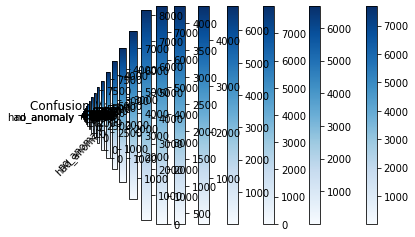

In [ ]:
import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import holidays
import json
import copy
import numpy as np
import torch
import random
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
seed=42
torch.backends.cudnn.determinestic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
import pandas as pd
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)


def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))
class MCD_AE(nn.Module):

    def __init__(self, n_features, output_length, batch_size):
        super(MCD_AE, self).__init__()

        self.batch_size = batch_size  # user-defined

        self.hidden_size_1 = 128
        self.hidden_size_2 = 32
        self.stacked_layers = 2
        self.dropout_probability = 0.5  # arbitrary value (the paper suggests that performance is generally stable across all ranges)


        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)

        output, _ = self.lstm1(x, hidden)

        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :]  # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state

    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

###Prepare Labels
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

# %%
os.makedirs('csv', exist_ok=True)

# %%
selected_columns = ['index', 'name',  'value']



df_label = pd.read_csv(CSV_URL)

#name='F-7'
MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']






SMAP=pd.Series(SMAP)
MSL=pd.Series(MSL)

#pdb.set_trace()
avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=0
training_truth_df=pd.DataFrame()

for name in SMAP:

        label_row = df_label[df_label.chan_id == name]
    # pdb.set_trace()

        labels = label_row.anomaly_sequences[im]
        labels = eval(labels)

        true_indices_grouped = [list(range(e[0], e[1] + 1)) for e in labels]
        true_indices_flat = set([i for group in true_indices_grouped for i in group])

        appended_data = []

        labels = true_indices_flat

    # for i in range(len(labels)):
    #    anom=labels[i]
    # start=anom[0]
    # end=anom[1]

        index = list(labels)

    # timestamp = index * 86400 + 1022819200

        anomalies = pd.DataFrame({'value': 1, 'index': index})
    #     appended_data.append(anomalies)

        label_data = anomalies

    # label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
    # label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data['name'] = name
    # label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
    # label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)


        #label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        #label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        #label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        #label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'name']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        #plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 10

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)

        #sns.displot(data=y_test,  kind="hist", bins=100, aspect=1.5)
      #  plt.show()
       # pdb.set_trace()

        #f = Fitter(y_train,
         #          distributions=['gamma',
          #                        'lognorm',
           #                       "beta",
            #                      "burr",
             #                     "norm",'cauchy', 'chi2', 'expon', 'exponpow', 'powerlaw', 'rayleigh', 'uniform'])
        #f.fit()
        #f.summary()
        #pdb.set_trace()
        n_features = scaled_array.shape[-1]
        sequence_length = 10
        output_length = 1

        batch_size = 64
        n_epochs = 10
        learning_rate = 0.01

        bayesian_lstm = MCD_AE(n_features=n_features,
                                     output_length=output_length,
                                     batch_size=batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)
        bayesian_lstm.train()

        for e in range(1, n_epochs + 1):
            for b in range(0, len(X_train), batch_size):
                features = X_train[b:b + batch_size, :, :]
                target = y_train[b:b + batch_size]

                X_batch = torch.tensor(features, dtype=torch.float32)
                y_batch = torch.tensor(target, dtype=torch.float32)
               # pdb.set_trace()

                output = bayesian_lstm(X_batch)
                loss = criterion(output.view(-1), y_batch)


                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if e % 10 == 0:
                print('epoch', e, 'loss: ', loss.item())
                offset = sequence_length

        training_df = pd.DataFrame()
       # training_df['date'] = resample_df['date'].iloc[offset:n_train + offset:1]
        training_df['index'] = resample_df['index'].iloc[offset:n_train + offset:1]
        training_predictions = bayesian_lstm.predict(X_train)


        training_df['value'] = inverse_transform(training_predictions)
        training_df['source'] = 'Training Prediction'


        #training_truth_df['date'] = training_df['date']
        training_truth_df['index'] = training_df['index']
        training_truth_df['value'] = resample_df['value'].iloc[
                                     offset:n_train + offset:1]
        training_truth_df['source'] = 'True Values'

        testing_df = pd.DataFrame()
        #testing_df['date'] = resample_df_test['date'].iloc[offset:n_test + offset:1]
        testing_df['index'] = resample_df_test['index'].iloc[offset:n_test + offset:1]

        testing_predictions = bayesian_lstm.predict(X_test)

        testing_df['value'] = inverse_transform(testing_predictions)
        testing_df['source'] = 'Test Prediction'

        testing_truth_df = pd.DataFrame()
        #testing_truth_df['date'] = testing_df['date']
        testing_truth_df['index'] = testing_df['index']

        testing_truth_df['value'] = resample_df_test['value'].iloc[offset:n_test + offset:1]
        testing_truth_df['source'] = 'True Values'


        evaluation = pd.concat([training_df,
                                testing_df,
                                training_truth_df,
                                testing_truth_df
                                ], axis=0)

        fig = px.line(evaluation,
                             x="index",
                              y="value",
                              color="source")
        #fig.show()

        n_experiments = 2
        test_uncertainty_df = pd.DataFrame()
        #test_uncertainty_df['date'] = testing_df['date']
        test_uncertainty_df['index'] = testing_df['index']

        for i in range(n_experiments):
            experiment_predictions = bayesian_lstm.predict(X_test)

            test_uncertainty_df['value_{}'.format(i)] = inverse_transform(experiment_predictions)

        log_energy_consumption_df = test_uncertainty_df.filter(like='value', axis=1)
        test_uncertainty_df['value_mean'] = log_energy_consumption_df.mean(axis=1)
        test_uncertainty_df['value_std'] = log_energy_consumption_df.std(axis=1)


        test_uncertainty1 = test_uncertainty_df['value_mean']

        #########################Adaptive Smoothing

        #   pdb.set_trace()
        Threshold = 10
        gamma = 0.1
        betta = 0.1
        test_uncertainty2 = []
        ###########
        for jj in range(len(test_uncertainty1) - 2):
            test_uncertaintyy = (1 / (1 + gamma + betta)) * (
                        test_uncertainty1.iloc[jj] + gamma * test_uncertainty1.iloc[jj + 1] + betta *
                        test_uncertainty1.iloc[jj + 2])
            test_uncertainty2.append(test_uncertaintyy)
        test_uncertainty2 = pd.DataFrame(test_uncertainty2)

        test_uncertainty2.columns = ["value_mean"]


        test_uncertainty_df["value_mean"] = test_uncertainty2["value_mean"]

        ########################################################


        test_uncertainty_df = test_uncertainty_df[['index',  'value_mean', 'value_std']]
        test_uncertainty_df['lower_bound'] = test_uncertainty_df['value_mean'] - 5* test_uncertainty_df['value_std']
        test_uncertainty_df['upper_bound'] = test_uncertainty_df['value_mean'] + 5* test_uncertainty_df['value_std']
        import plotly.graph_objects as go

        test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
        # test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2016-05-01', '2016-05-09')]
        truth_uncertainty_plot_df = testing_truth_df.copy(deep=True)
        # truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_truth_df['date'].between('2016-05-01', '2016-05-09')]

        upper_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['upper_bound'],
          mode='lines',
         fill=None,
         name='99% Upper Confidence Bound'
         )
        lower_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['lower_bound'],
          mode='lines',
          fill='tonexty',
         name= '99% Lower Confidence Bound',
         fillcolor='rgba(255, 211, 0, 0.1)',
         )
        real_trace = go.Scatter(
            x=truth_uncertainty_plot_df['index'],
            y=truth_uncertainty_plot_df['value'],
            mode='lines',
            fill=None,
            name='Real Values'
        )

        labels = go.Scatter(
           x=label_data['index'],
          y=label_data['value'],
         mode='lines',
         fill='tonexty' ,
         name='labels'
         )
        data = [upper_trace, lower_trace, real_trace]

        fig = go.Figure(data=data)
        fig.update_layout(title='Uncertainty MCDropout Test Data',
                            xaxis_title='index',
                            yaxis_title='value',
         legend_font_size=14,
                          )
        #fig.show()
        bounds_df = pd.DataFrame()

        # Using 99% confidence bounds
        bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
        bounds_df['prediction'] = test_uncertainty_plot_df['value_mean']
        bounds_df['real_value'] = truth_uncertainty_plot_df['value']
        bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

        bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                                  (bounds_df['real_value'] <= bounds_df['upper_bound']))

        print("Proportion of points contained within 99% confidence interval:",
              bounds_df['contained'].mean())
        predictedanomaly = bounds_df.index[~bounds_df['contained']]
        predictedanomaly = bounds_df.index[~bounds_df['contained']]

        N = 15
        newarr = []


        for i in range(len(predictedanomaly) - N):
            if (predictedanomaly[i] + 1 == predictedanomaly[i + 1] and predictedanomaly[i + 1] + 1 == predictedanomaly[
               i + 2] and predictedanomaly[i+3]+1==predictedanomaly[i+4] and predictedanomaly[i+4]+1==predictedanomaly[i+5]
                and  predictedanomaly[i+5]+1==predictedanomaly[i+6] and predictedanomaly[i+6]+1==predictedanomaly[i+7]
                and predictedanomaly[i+7]+1==predictedanomaly[i+8]
                and predictedanomaly[i+8]+1==predictedanomaly[i+9]
                and predictedanomaly[i+9]+1==predictedanomaly[i+10]
                and predictedanomaly[i+10]+1==predictedanomaly[i+11]
                and predictedanomaly[i+11]+1==predictedanomaly[i+12]
                and predictedanomaly[i + 12] + 1 == predictedanomaly[i + 13]
                and predictedanomaly[i + 13] + 1 == predictedanomaly[i + 14]
                and predictedanomaly[i + 14] + 1 == predictedanomaly[i + 15]):

                newarr.append(predictedanomaly[i])
        #        newarr.append(predictedanomaly[i + 1])
         #       newarr.append(predictedanomaly[i + 2])


        predicteddanomaly = list(set(newarr))




        realanomaly = label_data['index']

        predicter=list(range(len(test_uncertainty2)))

        a1 = pd.DataFrame(index=range(len(test_uncertainty2)),columns=range(2))
        a1.columns=['index','value']

        a2 = pd.DataFrame(index=range(len(test_uncertainty2)), columns=range(2))
        a2.columns = ['index','value']




        for i in range(len(predicter)):
            if i in predicteddanomaly:
                a1.iloc[i,1]=1
            else:
                a1.iloc[i,1]=0

        for i in range(len(predicter)):
            if i in realanomaly:
                a2.iloc[i,1] = 1
            else:
                a2.iloc[i, 1] = 0



        y_real=a2.value
        y_real=y_real.astype(int)
        y_predi=a1.value
        y_predi=y_predi.astype(int)


        cm = confusion_matrix(y_true=y_real, y_pred=y_predi)
        cm_plot_labels = ['no_anomaly', 'had_anomaly']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

        # tp = len([np.where(predicteddanomaly == x)[0] for x in realanomaly])
        #fp = len(predicteddanomaly) - tp
        #fn = 0
        #tn = len(truth_uncertainty_plot_df) - tp - fp - fn

        tp=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tn=cm[1][1]

        precision1 = tp / (tp + fp)
        recall1 = tp / (tp + fn)
        Accuracy1 = (tp + tn) / len(truth_uncertainty_plot_df)
        F11 = 2 / ((1 / precision1) + (1 / recall1))
        print('precision', precision1, 'Signal', name)
        print('recall', recall1, 'Signal', name)
        print('Accuracy', Accuracy1, 'Signal', name)
        print('F1', F11, 'Signal', name)
        precision.append(precision1)
        F1.append(F11)
        Accuracy.append(Accuracy1)
        recall.append(recall1)

        im=im+1

        #matched_indices = list(i_anom_predicted & true_indices_flat)


recall_final=mean(recall)
precision_final=mean(precision)
F1_final=mean(F1)
Accuracy_final=mean(Accuracy)


print('precision_final', precision_final)
print('recall_final', recall_final)
print('Accuracy_final',Accuracy_final)
print('F1_final', F1_final)

        #matched_indices = list(i_anom_predicted & true_indices_flat)


#cm = confusion_matrix(y_true=test_labels, y_pred=predicteddanomaly)

################################################################################

# %%

## New Test Bayesian LSTM AE



## Lets try different  network Configuration as in the Paper to increase their accuracy

epoch 10 loss:  0.021653199568390846


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.40388463802236607
Confusion matrix, without normalization
[[7713   29]
 [ 748    3]]
precision 0.9962541978816843 Signal P-1
recall 0.9115943741874483 Signal P-1
Accuracy 0.9082989994114185 Signal P-1
F1 0.9520459174226995 Signal P-1
epoch 10 loss:  0.12718886137008667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.067203933888813
Confusion matrix, without normalization
[[4024 2847]
 [ 299  149]]
precision 0.5856498326298938 Signal S-1
recall 0.9308350682396483 Signal S-1
Accuracy 0.5700040978008469 Signal S-1
F1 0.7189565838842237 Signal S-1
epoch 10 loss:  0.048873089253902435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5262167881495415
Confusion matrix, without normalization
[[7984   12]
 [ 508    0]]
precision 0.9984992496248124 Signal E-1
recall 0.9401789919924635 Signal E-1
Accuracy 0.9386315541970374 Signal E-1
F1 0.9684619116933528 Signal E-1
epoch 10 loss:  0.022810781374573708


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5998591879840413
Confusion matrix, without normalization
[[7119    3]
 [1397    1]]
precision 0.9995787700084247 Signal E-2
recall 0.835955847815876 Signal E-2
Accuracy 0.8354846280215912 Signal E-2
F1 0.9104744852282901 Signal E-2
epoch 10 loss:  0.02617497555911541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 5079]
 [  10 3203]]
precision 0.0005903187721369539 Signal E-3
recall 0.23076923076923078 Signal E-3
Accuracy 0.38640472459925274 Signal E-3
F1 0.0011776251226692837 Signal E-3
epoch 10 loss:  0.007089213468134403


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7114093959731543
Confusion matrix, without normalization
[[5530    0]
 [2812    0]]
precision 1.0 Signal E-4
recall 0.6629105730040757 Signal E-4
Accuracy 0.662751677852349 Signal E-4
F1 0.7972895040369088 Signal E-4
epoch 10 loss:  0.06599296629428864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5124336069531628
Confusion matrix, without normalization
[[7936   25]
 [ 321    0]]
precision 0.9968596909935937 Signal E-5
recall 0.961123894877074 Signal E-5
Accuracy 0.9579913085465959 Signal E-5
F1 0.9786656801085213 Signal E-5
epoch 10 loss:  0.06702083349227905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.23896260554885404
Confusion matrix, without normalization
[[8009  213]
 [  64    2]]
precision 0.9740938944295792 Signal E-6
recall 0.9920723398984268 Signal E-6
Accuracy 0.9663449939686369 Signal E-6
F1 0.9830009205277692 Signal E-6
epoch 10 loss:  0.04607388377189636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.14397590361445783
Confusion matrix, without normalization
[[6984 1033]
 [ 269   12]]
precision 0.8711488087813396 Signal E-7
recall 0.9629118985247483 Signal E-7
Accuracy 0.8428915662650602 Signal E-7
F1 0.9147347740667976 Signal E-7
epoch 10 loss:  0.008940670639276505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4845106782445435
Confusion matrix, without normalization
[[7784  113]
 [ 620    3]]
precision 0.9856907686463214 Signal E-8
recall 0.9262256068538791 Signal E-8
Accuracy 0.9137526402252992 Signal E-8
F1 0.9550334335316851 Signal E-8
epoch 10 loss:  0.00665458757430315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5012059816690786
Confusion matrix, without normalization
[[7896   43]
 [ 351    0]]
precision 0.9945837007179745 Signal E-9
recall 0.9574390687522736 Signal E-9
Accuracy 0.9522431259044862 Signal E-9
F1 0.9756579760286667 Signal E-9
epoch 10 loss:  0.08193107694387436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.549970570924073
Confusion matrix, without normalization
[[8166    5]
 [ 321    1]]
precision 0.9993880797943948 Signal E-10
recall 0.9621774478614351 Signal E-10
Accuracy 0.9613890523837552 Signal E-10
F1 0.9804298235082242 Signal E-10
epoch 10 loss:  0.0952175110578537


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.424623706491063
Confusion matrix, without normalization
[[8165   42]
 [ 295    0]]
precision 0.9948824174485196 Signal E-11
recall 0.9651300236406619 Signal E-11
Accuracy 0.9601364063969896 Signal E-11
F1 0.9797804043919122 Signal E-11
epoch 10 loss:  0.0697559341788292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.47494707127734653
Confusion matrix, without normalization
[[7908    9]
 [ 583    0]]
precision 0.9988632057597575 Signal E-12
recall 0.9313390648922388 Signal E-12
Accuracy 0.9301340860973889 Signal E-12
F1 0.9639200390053632 Signal E-12
epoch 10 loss:  0.02623622864484787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5310544611819236
Confusion matrix, without normalization
[[8272   92]
 [ 256    8]]
precision 0.9890004782400765 Signal E-13
recall 0.9699812382739212 Signal E-13
Accuracy 0.9594438006952491 Signal E-13
F1 0.9793985318493962 Signal E-13
epoch 10 loss:  1.9581311505589838e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3979142526071842
Confusion matrix, without normalization
[[8541    2]
 [  85    0]]
precision 0.999765890202505 Signal A-1
recall 0.9901460700208672 Signal A-1
Accuracy 0.9896871378910777 Signal A-1
F1 0.9949327275904245 Signal A-1
epoch 10 loss:  0.006594732403755188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4180491822567361
Confusion matrix, without normalization
[[2334 2904]
 [3249   10]]
precision 0.44558991981672397 Signal D-1
recall 0.41805480924234284 Signal D-1
Accuracy 0.275797152606189 Signal D-1
F1 0.4313834211255891 Signal D-1
epoch 10 loss:  0.027230149134993553


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4211489206000732
Confusion matrix, without normalization
[[6956   15]
 [1205   21]]
precision 0.9978482283746951 Signal P-2
recall 0.8523465261610097 Signal P-2
Accuracy 0.8509574338333943 Signal P-2
F1 0.9193761564895585 Signal P-2
epoch 10 loss:  0.0028473034035414457


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.44571495933042554
Confusion matrix, without normalization
[[7122   23]
 [1335    1]]
precision 0.996780965710287 Signal P-3
recall 0.8421426037601987 Signal P-3
Accuracy 0.8396793587174348 Signal P-3
F1 0.912959876938854 Signal P-3
epoch 10 loss:  7.216658559627831e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4821199767035527
Confusion matrix, without normalization
[[ 575 3790]
 [4218    0]]
precision 0.13172966781214204 Signal D-2
recall 0.11996661798456082 Signal D-2
Accuracy 0.0669772859638905 Signal D-2
F1 0.125573269272767 Signal D-2
epoch 10 loss:  0.1990908682346344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0003476245654692932
Confusion matrix, without normalization
[[   3 5349]
 [  44 3232]]
precision 0.0005605381165919282 Signal D-3
recall 0.06382978723404255 Signal D-3
Accuracy 0.37485515643105444 Signal D-3
F1 0.0011113169105389886 Signal D-3
epoch 10 loss:  0.2860288619995117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0004726456339359565
Confusion matrix, without normalization
[[  63 5150]
 [  10 3238]]
precision 0.012085171686169193 Signal D-4
recall 0.863013698630137 Signal D-4
Accuracy 0.3900508094056481 Signal D-4
F1 0.02383654937570942 Signal D-4
epoch 10 loss:  0.01677125319838524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5285931174089069
Confusion matrix, without normalization
[[7616  175]
 [ 111    0]]
precision 0.977538185085355 Signal A-2
recall 0.9856347871101333 Signal A-2
Accuracy 0.9635627530364372 Signal A-2
F1 0.9815697899213817 Signal A-2
epoch 10 loss:  0.00913576502352953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5823062843197071
Confusion matrix, without normalization
[[8005    2]
 [ 186    0]]
precision 0.9997502185587611 Signal A-3
recall 0.9772921499206446 Signal A-3
Accuracy 0.9768151311775473 Signal A-3
F1 0.9883936288430669 Signal A-3
epoch 10 loss:  0.007517233490943909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5664188351920694
Confusion matrix, without normalization
[[7956    1]
 [ 111    0]]
precision 0.9998743244941561 Signal A-4
recall 0.9862402380066939 Signal A-4
Accuracy 0.9858736059479554 Signal A-4
F1 0.9930104842735896 Signal A-4
epoch 10 loss:  0.01854415237903595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4125783189502305
Confusion matrix, without normalization
[[6644 1692]
 [  10  111]]
precision 0.7970249520153551 Signal G-1
recall 0.998497144574692 Signal G-1
Accuracy 0.7985577491429247 Signal G-1
F1 0.886457638425617 Signal G-1
epoch 10 loss:  7.147851647459902e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8465514895932527
Confusion matrix, without normalization
[[7308    0]
 [  41    0]]
precision 1.0 Signal G-2
recall 0.9944210096611784 Signal G-2
Accuracy 0.9941504557203101 Signal G-2
F1 0.9972027017807191 Signal G-2
epoch 10 loss:  0.005827001761645079


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 7562]
 [  10   41]]
precision 0.0003965631196298744 Signal D-5
recall 0.23076923076923078 Signal D-5
Accuracy 0.005775794171698608 Signal D-5
F1 0.000791765637371338 Signal D-5
epoch 10 loss:  0.0072772689163684845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7901955803911608
Confusion matrix, without normalization
[[7791    0]
 [  81    0]]
precision 1.0 Signal D-6
recall 0.9897103658536586 Signal D-6
Accuracy 0.9894589789179579 Signal D-6
F1 0.9948285769009769 Signal D-6
epoch 10 loss:  9.481572305958252e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5686582809224319
Confusion matrix, without normalization
[[2339 2589]
 [2702    0]]
precision 0.4746347402597403 Signal D-7
recall 0.46399523903987305 Signal D-7
Accuracy 0.3064727463312369 Signal D-7
F1 0.4692546895375664 Signal D-7
epoch 10 loss:  0.024613402783870697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.28306508047585727
Confusion matrix, without normalization
[[8400   71]
 [ 101    0]]
precision 0.9916184629913823 Signal F-1
recall 0.9881190448182566 Signal F-1
Accuracy 0.979706088173548 Signal F-1
F1 0.9898656610888521 Signal F-1
epoch 10 loss:  7.3241753852926195e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8238775247652129
Confusion matrix, without normalization
[[7328    0]
 [ 443    0]]
precision 1.0 Signal P-4
recall 0.9429931797709432 Signal P-4
Accuracy 0.942750546764441 Signal P-4
F1 0.9706603086297105 Signal P-4
epoch 10 loss:  0.00034760430571623147


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8595669241484107
Confusion matrix, without normalization
[[7844    0]
 [  51    0]]
precision 1.0 Signal G-3
recall 0.9935402153261558 Signal G-3
Accuracy 0.9932885906040269 Signal G-3
F1 0.9967596416544887 Signal G-3
epoch 10 loss:  0.019417954608798027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4437340153452685
Confusion matrix, without normalization
[[6970   94]
 [1533    3]]
precision 0.9866930917327293 Signal T-1
recall 0.8197106903445842 Signal T-1
Accuracy 0.810625435945129 Signal T-1
F1 0.8954840367443953 Signal T-1
epoch 10 loss:  0.004737915005534887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.648752176436448
Confusion matrix, without normalization
[[6826    2]
 [1782    3]]
precision 0.9997070884592852 Signal T-2
recall 0.7929832713754646 Signal T-2
Accuracy 0.7926871735345328 Signal T-2
F1 0.8844260171028765 Signal T-2
epoch 10 loss:  3.923633812519256e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8296032553407935
Confusion matrix, without normalization
[[7811    0]
 [  51    0]]
precision 1.0 Signal D-8
recall 0.993513100992114 Signal D-8
Accuracy 0.9932604272634792 Signal D-8
F1 0.9967459962993683 Signal D-8
epoch 10 loss:  7.396241016977001e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7528393726338561
Confusion matrix, without normalization
[[5339  899]
 [1156    0]]
precision 0.8558832959281821 Signal D-9
recall 0.822016936104696 Signal D-9
Accuracy 0.7218766901027582 Signal D-9
F1 0.8386083405324748 Signal D-9
epoch 10 loss:  0.03976587951183319


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.19498607242339833
Confusion matrix, without normalization
[[4119 1538]
 [1795 1162]]
precision 0.7281244475870603 Signal F-2
recall 0.696482921880284 Signal F-2
Accuracy 0.6129294336118849 Signal F-2
F1 0.711952294529427 Signal F-2
epoch 10 loss:  0.12743757665157318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6162424560482813
Confusion matrix, without normalization
[[7589    0]
 [  31    0]]
precision 1.0 Signal G-4
recall 0.9959317585301837 Signal G-4
Accuracy 0.9956704277092626 Signal G-4
F1 0.9979617331842988 Signal G-4
epoch 10 loss:  0.006901921238750219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6123234916559692
Confusion matrix, without normalization
[[8288   95]
 [ 184    0]]
precision 0.9886675414529404 Signal T-3
recall 0.9782813975448537 Signal T-3
Accuracy 0.9672073754230365 Signal T-3
F1 0.9834470483536043 Signal T-3
epoch 10 loss:  0.3631185293197632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 7355]
 [  10   51]]
precision 0.0004077194889915738 Signal D-11
recall 0.23076923076923078 Signal D-11
Accuracy 0.00727664735210888 Signal D-11
F1 0.000814000814000814 Signal D-11
epoch 10 loss:  4.2881427361862734e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5881385938290339
Confusion matrix, without normalization
[[3117 2049]
 [2740    0]]
precision 0.6033681765389083 Signal D-12
recall 0.5321837117978487 Signal D-12
Accuracy 0.3941578148710167 Signal D-12
F1 0.5655447700263087 Signal D-12
epoch 10 loss:  5.547624823520891e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5054767239233259
Confusion matrix, without normalization
[[5009 2952]
 [  71    0]]
precision 0.6291923125235523 Signal B-1
recall 0.9860236220472441 Signal B-1
Accuracy 0.6234752302713468 Signal B-1
F1 0.7681926232650871 Signal B-1
epoch 10 loss:  0.20506338775157928


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 8524]
 [  10   91]]
precision 0.0003518236190922951 Signal G-6
recall 0.23076923076923078 Signal G-6
Accuracy 0.01089223638470452 Signal G-6
F1 0.000702576112412178 Signal G-6
epoch 10 loss:  0.0016818731091916561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.811821922933034
Confusion matrix, without normalization
[[7748    1]
 [ 268    0]]
precision 0.9998709510904633 Signal G-7
recall 0.966566866267465 Signal G-7
Accuracy 0.9662052625015588 Signal G-7
F1 0.9829368855058673 Signal G-7
epoch 10 loss:  0.001284722937270999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4861679692345863
Confusion matrix, without normalization
[[6130  278]
 [1649    2]]
precision 0.9566167290886392 Signal P-7
recall 0.7880190255816943 Signal P-7
Accuracy 0.7606996650539636 Signal P-7
F1 0.8641714245435962 Signal P-7
epoch 10 loss:  1.6221196119658998e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8462814487144042
Confusion matrix, without normalization
[[7151    0]
 [  81    0]]
precision 1.0 Signal R-1
recall 0.988799778761062 Signal R-1
Accuracy 0.9885264030964888 Signal R-1
F1 0.9943683515261073 Signal R-1
epoch 10 loss:  0.0398695282638073


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0800768737988469
Confusion matrix, without normalization
[[2429 2201]
 [  51    0]]
precision 0.524622030237581 Signal A-5
recall 0.9794354838709678 Signal A-5
Accuracy 0.5186846038863976 Signal A-5
F1 0.6832630098452883 Signal A-5
epoch 10 loss:  0.20230413973331451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.804636506864731
Confusion matrix, without normalization
[[4400    0]
 [  41    0]]
precision 1.0 Signal A-6
recall 0.990767845079937 Signal A-6
Accuracy 0.9903218546027459 Signal A-6
F1 0.9953625155525393 Signal A-6
epoch 10 loss:  0.005574063863605261


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.463519313304721
Confusion matrix, without normalization
[[6197   21]
 [2396    5]]
precision 0.9966227082663236 Signal A-7
recall 0.7211683928779239 Signal A-7
Accuracy 0.7194061013803503 Signal A-7
F1 0.8368104786982649 Signal A-7
epoch 10 loss:  1.6221190890064463e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5441003528028224
Confusion matrix, without normalization
[[4934 2556]
 [ 161    0]]
precision 0.6587449933244326 Signal D-13
recall 0.9684003925417075 Signal D-13
Accuracy 0.6447144910492617 Signal D-13
F1 0.7841080651569329 Signal D-13
epoch 10 loss:  0.027095351368188858


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5588486400780583
Confusion matrix, without normalization
[[7063   13]
 [1121    0]]
precision 0.9981628038439796 Signal P-2
recall 0.8630254154447703 Signal P-2
Accuracy 0.8614465178680327 Signal P-2
F1 0.9256880733944954 Signal P-2
epoch 10 loss:  0.006392116192728281


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5148834429169157
Confusion matrix, without normalization
[[4444  113]
 [3235  571]]
precision 0.9752029844195743 Signal A-8
recall 0.5787211876546425 Signal A-8
Accuracy 0.5995218170950388 Signal A-8
F1 0.7263811703170971 Signal A-8
epoch 10 loss:  0.056935373693704605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.28525641025641024
Confusion matrix, without normalization
[[4141  416]
 [3844   21]]
precision 0.9087118718455124 Signal A-9
recall 0.5185973700688792 Signal A-9
Accuracy 0.4940645773979107 Signal A-9
F1 0.6603412533886143 Signal A-9
epoch 10 loss:  0.20704133808612823


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.005139851781018408
Confusion matrix, without normalization
[[ 266 8057]
 [  10   31]]
precision 0.031959629941127 Signal F-3
recall 0.9637681159420289 Signal F-3
Accuracy 0.035500836720057376 Signal F-3
F1 0.06186765903011978 Signal F-3
precision_final 0.7827852989338251
recall_final 0.8044962387948151
Accuracy_final 0.7268994629149781
F1_final 0.7617486207041171


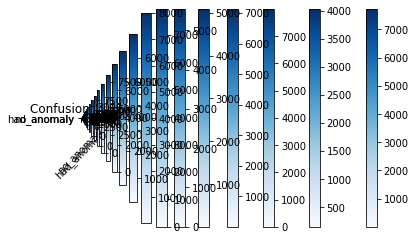

In [ ]:

import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import random
import holidays
import json
import copy
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
import pandas as pd
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')
seed=42
torch.backends.cudnn.determinestic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)


def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))
class MCD_AE(nn.Module):

    def __init__(self, n_features, output_length, batch_size):
        super(MCD_AE, self).__init__()

        self.batch_size = batch_size  # user-defined

        self.hidden_size_1 = 64
        self.hidden_size_2 = 8
        self.stacked_layers = 1
        self.dropout_probability = 0.5  # arbitrary value (the paper suggests that performance is generally stable across all ranges)


        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)

        output, _ = self.lstm1(x, hidden)

        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :]  # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state

    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

###Prepare Labels
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

# %%
os.makedirs('csv', exist_ok=True)

# %%
selected_columns = ['index', 'name',  'value']



df_label = pd.read_csv(CSV_URL)

#name='F-7'
MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']






SMAP=pd.Series(SMAP)
MSL=pd.Series(MSL)

#pdb.set_trace()
avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=0
training_truth_df=pd.DataFrame()

for name in SMAP:

        label_row = df_label[df_label.chan_id == name]
    # pdb.set_trace()

        labels = label_row.anomaly_sequences[im]
        labels = eval(labels)

        true_indices_grouped = [list(range(e[0], e[1] + 1)) for e in labels]
        true_indices_flat = set([i for group in true_indices_grouped for i in group])

        appended_data = []

        labels = true_indices_flat

    # for i in range(len(labels)):
    #    anom=labels[i]
    # start=anom[0]
    # end=anom[1]

        index = list(labels)

    # timestamp = index * 86400 + 1022819200

        anomalies = pd.DataFrame({'value': 1, 'index': index})
    #     appended_data.append(anomalies)

        label_data = anomalies

    # label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
    # label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data['name'] = name
    # label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
    # label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)


        #label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        #label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        #label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        #label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'name']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        #plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 10

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)

        #sns.displot(data=y_test,  kind="hist", bins=100, aspect=1.5)
      #  plt.show()
       # pdb.set_trace()

        #f = Fitter(y_train,
         #          distributions=['gamma',
          #                        'lognorm',
           #                       "beta",
            #                      "burr",
             #                     "norm",'cauchy', 'chi2', 'expon', 'exponpow', 'powerlaw', 'rayleigh', 'uniform'])
        #f.fit()
        #f.summary()
        #pdb.set_trace()
        n_features = scaled_array.shape[-1]
        sequence_length = 10
        output_length = 1

        batch_size = 64
        n_epochs = 10
        learning_rate = 0.01

        bayesian_lstm = MCD_AE(n_features=n_features,
                                     output_length=output_length,
                                     batch_size=batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)
        bayesian_lstm.train()

        for e in range(1, n_epochs + 1):
            for b in range(0, len(X_train), batch_size):
                features = X_train[b:b + batch_size, :, :]
                target = y_train[b:b + batch_size]

                X_batch = torch.tensor(features, dtype=torch.float32)
                y_batch = torch.tensor(target, dtype=torch.float32)
               # pdb.set_trace()

                output = bayesian_lstm(X_batch)
                loss = criterion(output.view(-1), y_batch)


                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if e % 10 == 0:
                print('epoch', e, 'loss: ', loss.item())
                offset = sequence_length

        training_df = pd.DataFrame()
       # training_df['date'] = resample_df['date'].iloc[offset:n_train + offset:1]
        training_df['index'] = resample_df['index'].iloc[offset:n_train + offset:1]
        training_predictions = bayesian_lstm.predict(X_train)


        training_df['value'] = inverse_transform(training_predictions)
        training_df['source'] = 'Training Prediction'


        #training_truth_df['date'] = training_df['date']
        training_truth_df['index'] = training_df['index']
        training_truth_df['value'] = resample_df['value'].iloc[
                                     offset:n_train + offset:1]
        training_truth_df['source'] = 'True Values'

        testing_df = pd.DataFrame()
        #testing_df['date'] = resample_df_test['date'].iloc[offset:n_test + offset:1]
        testing_df['index'] = resample_df_test['index'].iloc[offset:n_test + offset:1]

        testing_predictions = bayesian_lstm.predict(X_test)

        testing_df['value'] = inverse_transform(testing_predictions)
        testing_df['source'] = 'Test Prediction'

        testing_truth_df = pd.DataFrame()
        #testing_truth_df['date'] = testing_df['date']
        testing_truth_df['index'] = testing_df['index']

        testing_truth_df['value'] = resample_df_test['value'].iloc[offset:n_test + offset:1]
        testing_truth_df['source'] = 'True Values'


        evaluation = pd.concat([training_df,
                                testing_df,
                                training_truth_df,
                                testing_truth_df
                                ], axis=0)

        fig = px.line(evaluation,
                             x="index",
                              y="value",
                              color="source")
        #fig.show()

        n_experiments = 2
        test_uncertainty_df = pd.DataFrame()
        #test_uncertainty_df['date'] = testing_df['date']
        test_uncertainty_df['index'] = testing_df['index']

        for i in range(n_experiments):
            experiment_predictions = bayesian_lstm.predict(X_test)

            test_uncertainty_df['value_{}'.format(i)] = inverse_transform(experiment_predictions)

        log_energy_consumption_df = test_uncertainty_df.filter(like='value', axis=1)
        test_uncertainty_df['value_mean'] = log_energy_consumption_df.mean(axis=1)
        test_uncertainty_df['value_std'] = log_energy_consumption_df.std(axis=1)


        test_uncertainty1 = test_uncertainty_df['value_mean']

        #########################Adaptive Smoothing

        #   pdb.set_trace()
        Threshold = 10
        gamma = 0.1
        betta = 0.1
        test_uncertainty2 = []
        ###########
        for jj in range(len(test_uncertainty1) - 2):
            test_uncertaintyy = (1 / (1 + gamma + betta)) * (
                        test_uncertainty1.iloc[jj] + gamma * test_uncertainty1.iloc[jj + 1] + betta *
                        test_uncertainty1.iloc[jj + 2])
            test_uncertainty2.append(test_uncertaintyy)
        test_uncertainty2 = pd.DataFrame(test_uncertainty2)

        test_uncertainty2.columns = ["value_mean"]


        test_uncertainty_df["value_mean"] = test_uncertainty2["value_mean"]

        ########################################################


        test_uncertainty_df = test_uncertainty_df[['index',  'value_mean', 'value_std']]
        test_uncertainty_df['lower_bound'] = test_uncertainty_df['value_mean'] - 3* test_uncertainty_df['value_std']
        test_uncertainty_df['upper_bound'] = test_uncertainty_df['value_mean'] + 3* test_uncertainty_df['value_std']
        import plotly.graph_objects as go

        test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
        # test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2016-05-01', '2016-05-09')]
        truth_uncertainty_plot_df = testing_truth_df.copy(deep=True)
        # truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_truth_df['date'].between('2016-05-01', '2016-05-09')]

        upper_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['upper_bound'],
          mode='lines',
         fill=None,
         name='99% Upper Confidence Bound'
         )
        lower_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['lower_bound'],
          mode='lines',
          fill='tonexty',
         name= '99% Lower Confidence Bound',
         fillcolor='rgba(255, 211, 0, 0.1)',
         )
        real_trace = go.Scatter(
            x=truth_uncertainty_plot_df['index'],
            y=truth_uncertainty_plot_df['value'],
            mode='lines',
            fill=None,
            name='Real Values'
        )

        labels = go.Scatter(
           x=label_data['index'],
          y=label_data['value'],
         mode='lines',
         fill='tonexty' ,
         name='labels'
         )
        data = [upper_trace, lower_trace, real_trace]

        fig = go.Figure(data=data)
        fig.update_layout(title='Uncertainty MCDropout Test Data',
                            xaxis_title='index',
                            yaxis_title='value',
         legend_font_size=14,
                          )
        #fig.show()
        bounds_df = pd.DataFrame()

        # Using 99% confidence bounds
        bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
        bounds_df['prediction'] = test_uncertainty_plot_df['value_mean']
        bounds_df['real_value'] = truth_uncertainty_plot_df['value']
        bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

        bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                                  (bounds_df['real_value'] <= bounds_df['upper_bound']))

        print("Proportion of points contained within 99% confidence interval:",
              bounds_df['contained'].mean())
        predictedanomaly = bounds_df.index[~bounds_df['contained']]
        predictedanomaly = bounds_df.index[~bounds_df['contained']]

        N = 15
        newarr = []


        for i in range(len(predictedanomaly) - N):
            if (predictedanomaly[i] + 1 == predictedanomaly[i + 1] and predictedanomaly[i + 1] + 1 == predictedanomaly[
               i + 2] and predictedanomaly[i+3]+1==predictedanomaly[i+4] and predictedanomaly[i+4]+1==predictedanomaly[i+5]
                and  predictedanomaly[i+5]+1==predictedanomaly[i+6] and predictedanomaly[i+6]+1==predictedanomaly[i+7]
                and predictedanomaly[i+7]+1==predictedanomaly[i+8]
                and predictedanomaly[i+8]+1==predictedanomaly[i+9]
                and predictedanomaly[i+9]+1==predictedanomaly[i+10]
                and predictedanomaly[i+10]+1==predictedanomaly[i+11]
                and predictedanomaly[i+11]+1==predictedanomaly[i+12]
                and predictedanomaly[i + 12] + 1 == predictedanomaly[i + 13]
                and predictedanomaly[i + 13] + 1 == predictedanomaly[i + 14]
                and predictedanomaly[i + 14] + 1 == predictedanomaly[i + 15]):

                newarr.append(predictedanomaly[i])
        #        newarr.append(predictedanomaly[i + 1])
         #       newarr.append(predictedanomaly[i + 2])


        predicteddanomaly = list(set(newarr))




        realanomaly = label_data['index']

        predicter=list(range(len(test_uncertainty2)))

        a1 = pd.DataFrame(index=range(len(test_uncertainty2)),columns=range(2))
        a1.columns=['index','value']

        a2 = pd.DataFrame(index=range(len(test_uncertainty2)), columns=range(2))
        a2.columns = ['index','value']




        for i in range(len(predicter)):
            if i in predicteddanomaly:
                a1.iloc[i,1]=1
            else:
                a1.iloc[i,1]=0

        for i in range(len(predicter)):
            if i in realanomaly:
                a2.iloc[i,1] = 1
            else:
                a2.iloc[i, 1] = 0



        y_real=a2.value
        y_real=y_real.astype(int)
        y_predi=a1.value
        y_predi=y_predi.astype(int)


        cm = confusion_matrix(y_true=y_real, y_pred=y_predi)
        cm_plot_labels = ['no_anomaly', 'had_anomaly']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

        # tp = len([np.where(predicteddanomaly == x)[0] for x in realanomaly])
        #fp = len(predicteddanomaly) - tp
        #fn = 0
        #tn = len(truth_uncertainty_plot_df) - tp - fp - fn

        tp=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tn=cm[1][1]

        precision1 = tp / (tp + fp)
        recall1 = tp / (tp + fn)
        Accuracy1 = (tp + tn) / len(truth_uncertainty_plot_df)
        F11 = 2 / ((1 / precision1) + (1 / recall1))
        print('precision', precision1, 'Signal', name)
        print('recall', recall1, 'Signal', name)
        print('Accuracy', Accuracy1, 'Signal', name)
        print('F1', F11, 'Signal', name)
        precision.append(precision1)
        F1.append(F11)
        Accuracy.append(Accuracy1)
        recall.append(recall1)

        im=im+1

        #matched_indices = list(i_anom_predicted & true_indices_flat)


recall_final=mean(recall)
precision_final=mean(precision)
F1_final=mean(F1)
Accuracy_final=mean(Accuracy)


print('precision_final', precision_final)
print('recall_final', recall_final)
print('Accuracy_final',Accuracy_final)
print('F1_final', F1_final)

        #matched_indices = list(i_anom_predicted & true_indices_flat)


#cm = confusion_matrix(y_true=test_labels, y_pred=predicteddanomaly)

################################################################################

# %%

## New Test Bayesian LSTM AE



##Lets Try their exact Network Configurations (Without AE and With post-process)

We dont have many of their network parameters, such as dropout rate, stack layer number, sequencial length, the method of choosing the bounds, etc., we first put an arbitrary value for these parameters then at the end we will upload their data to tensor board and see the results

In [ ]:

import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import random
import holidays
import json
import copy
import numpy as np
import torch
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
import pandas as pd
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed=42
torch.backends.cudnn.determinestic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
import matplotlib.pyplot as plt
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    #tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    #if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
     #   print('Confusion matrix, without normalization')

    #print(cm)
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)


def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))
class MCD_AE(nn.Module):

    def __init__(self, n_features, output_length, batch_size):
        super(MCD_AE, self).__init__()

        self.batch_size = batch_size  # user-defined

        self.hidden_size_1 = 64
        self.hidden_size_2 = 16
        self.stacked_layers = 2
        self.dropout_probability = 0.5  #


        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)

        output, _ = self.lstm1(x, hidden)

        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :]  # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state

    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

###Prepare Labels
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

# %%
os.makedirs('csv', exist_ok=True)

# %%
selected_columns = ['index', 'name',  'value']



df_label = pd.read_csv(CSV_URL)

#name='F-7'
MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']






SMAP=pd.Series(SMAP)
MSL=pd.Series(MSL)

#pdb.set_trace()
avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=0
training_truth_df=pd.DataFrame()

for name in SMAP:

        label_row = df_label[df_label.chan_id == name]
    # pdb.set_trace()

        labels = label_row.anomaly_sequences[im]
        labels = eval(labels)

        true_indices_grouped = [list(range(e[0], e[1] + 1)) for e in labels]
        true_indices_flat = set([i for group in true_indices_grouped for i in group])

        appended_data = []

        labels = true_indices_flat

    # for i in range(len(labels)):
    #    anom=labels[i]
    # start=anom[0]
    # end=anom[1]

        index = list(labels)

    # timestamp = index * 86400 + 1022819200

        anomalies = pd.DataFrame({'value': 1, 'index': index})
    #     appended_data.append(anomalies)

        label_data = anomalies

    # label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
    # label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data['name'] = name
    # label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
    # label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)


        #label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        #label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        #label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        #label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'name']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        #plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 10

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)

        #sns.displot(data=y_test,  kind="hist", bins=100, aspect=1.5)
      #  plt.show()
       # pdb.set_trace()

        #f = Fitter(y_train,
         #          distributions=['gamma',
          #                        'lognorm',
           #                       "beta",
            #                      "burr",
             #                     "norm",'cauchy', 'chi2', 'expon', 'exponpow', 'powerlaw', 'rayleigh', 'uniform'])
        #f.fit()
        #f.summary()
        #pdb.set_trace()
        n_features = scaled_array.shape[-1]
        sequence_length = 10
        output_length = 1

        batch_size = 64
        n_epochs = 10
        learning_rate = 0.01

        bayesian_lstm = MCD_AE(n_features=n_features,
                                     output_length=output_length,
                                     batch_size=batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)
        bayesian_lstm.train()

        for e in range(1, n_epochs + 1):
            for b in range(0, len(X_train), batch_size):
                features = X_train[b:b + batch_size, :, :]
                target = y_train[b:b + batch_size]

                X_batch = torch.tensor(features, dtype=torch.float32)
                y_batch = torch.tensor(target, dtype=torch.float32)
               # pdb.set_trace()

                output = bayesian_lstm(X_batch)
                loss = criterion(output.view(-1), y_batch)


                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if e % 10 == 0:
                print('epoch', e, 'loss: ', loss.item())
                offset = sequence_length

        training_df = pd.DataFrame()
       # training_df['date'] = resample_df['date'].iloc[offset:n_train + offset:1]
        training_df['index'] = resample_df['index'].iloc[offset:n_train + offset:1]
        training_predictions = bayesian_lstm.predict(X_train)


        training_df['value'] = inverse_transform(training_predictions)
        training_df['source'] = 'Training Prediction'


        #training_truth_df['date'] = training_df['date']
        training_truth_df['index'] = training_df['index']
        training_truth_df['value'] = resample_df['value'].iloc[
                                     offset:n_train + offset:1]
        training_truth_df['source'] = 'True Values'

        testing_df = pd.DataFrame()
        #testing_df['date'] = resample_df_test['date'].iloc[offset:n_test + offset:1]
        testing_df['index'] = resample_df_test['index'].iloc[offset:n_test + offset:1]

        testing_predictions = bayesian_lstm.predict(X_test)

        testing_df['value'] = inverse_transform(testing_predictions)
        testing_df['source'] = 'Test Prediction'

        testing_truth_df = pd.DataFrame()
        #testing_truth_df['date'] = testing_df['date']
        testing_truth_df['index'] = testing_df['index']

        testing_truth_df['value'] = resample_df_test['value'].iloc[offset:n_test + offset:1]
        testing_truth_df['source'] = 'True Values'


        evaluation = pd.concat([training_df,
                                testing_df,
                                training_truth_df,
                                testing_truth_df
                                ], axis=0)

        fig = px.line(evaluation,
                             x="index",
                              y="value",
                              color="source")
        #fig.show()

        n_experiments = 2
        test_uncertainty_df = pd.DataFrame()
        #test_uncertainty_df['date'] = testing_df['date']
        test_uncertainty_df['index'] = testing_df['index']

        for i in range(n_experiments):
            experiment_predictions = bayesian_lstm.predict(X_test)

            test_uncertainty_df['value_{}'.format(i)] = inverse_transform(experiment_predictions)

        log_energy_consumption_df = test_uncertainty_df.filter(like='value', axis=1)
        test_uncertainty_df['value_mean'] = log_energy_consumption_df.mean(axis=1)
        test_uncertainty_df['value_std'] = log_energy_consumption_df.std(axis=1)


        test_uncertainty1 = test_uncertainty_df['value_mean']

        #########################Adaptive Smoothing

        #   pdb.set_trace()
        Threshold = 10
        gamma = 0.1
        betta = 0.1
        test_uncertainty2 = []
        ###########
        for jj in range(len(test_uncertainty1) - 2):
            test_uncertaintyy = (1 / (1 + gamma + betta)) * (
                        test_uncertainty1.iloc[jj] + gamma * test_uncertainty1.iloc[jj + 1] + betta *
                        test_uncertainty1.iloc[jj + 2])
            test_uncertainty2.append(test_uncertaintyy)
        test_uncertainty2 = pd.DataFrame(test_uncertainty2)

        test_uncertainty2.columns = ["value_mean"]


        test_uncertainty_df["value_mean"] = test_uncertainty2["value_mean"]

        ########################################################


        test_uncertainty_df = test_uncertainty_df[['index',  'value_mean', 'value_std']]
        test_uncertainty_df['lower_bound'] = test_uncertainty_df['value_mean'] - 3* test_uncertainty_df['value_std']
        test_uncertainty_df['upper_bound'] = test_uncertainty_df['value_mean'] + 3* test_uncertainty_df['value_std']
        import plotly.graph_objects as go

        test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
        # test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2016-05-01', '2016-05-09')]
        truth_uncertainty_plot_df = testing_truth_df.copy(deep=True)
        # truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_truth_df['date'].between('2016-05-01', '2016-05-09')]

        upper_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['upper_bound'],
          mode='lines',
         fill=None,
         name='99% Upper Confidence Bound'
         )
        lower_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['lower_bound'],
          mode='lines',
          fill='tonexty',
         name= '99% Lower Confidence Bound',
         fillcolor='rgba(255, 211, 0, 0.1)',
         )
        real_trace = go.Scatter(
            x=truth_uncertainty_plot_df['index'],
            y=truth_uncertainty_plot_df['value'],
            mode='lines',
            fill=None,
            name='Real Values'
        )

        labels = go.Scatter(
           x=label_data['index'],
          y=label_data['value'],
         mode='lines',
         fill='tonexty' ,
         name='labels'
         )
        data = [upper_trace, lower_trace, real_trace]

        fig = go.Figure(data=data)
        fig.update_layout(title='Uncertainty MCDropout Test Data',
                            xaxis_title='index',
                            yaxis_title='value',
         legend_font_size=14,
                          )
        #fig.show()
        bounds_df = pd.DataFrame()

        # Using 99% confidence bounds
        bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
        bounds_df['prediction'] = test_uncertainty_plot_df['value_mean']
        bounds_df['real_value'] = truth_uncertainty_plot_df['value']
        bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

        bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                                  (bounds_df['real_value'] <= bounds_df['upper_bound']))

        print("Proportion of points contained within 99% confidence interval:",
              bounds_df['contained'].mean())
        predictedanomaly = bounds_df.index[~bounds_df['contained']]
        predictedanomaly = bounds_df.index[~bounds_df['contained']]

        N = 15
        newarr = []


        for i in range(len(predictedanomaly) - N):
            if (predictedanomaly[i] + 1 == predictedanomaly[i + 1] and predictedanomaly[i + 1] + 1 == predictedanomaly[
               i + 2] and predictedanomaly[i+3]+1==predictedanomaly[i+4] and predictedanomaly[i+4]+1==predictedanomaly[i+5]
                and  predictedanomaly[i+5]+1==predictedanomaly[i+6] and predictedanomaly[i+6]+1==predictedanomaly[i+7]
                and predictedanomaly[i+7]+1==predictedanomaly[i+8]
                and predictedanomaly[i+8]+1==predictedanomaly[i+9]
                and predictedanomaly[i+9]+1==predictedanomaly[i+10]
                and predictedanomaly[i+10]+1==predictedanomaly[i+11]
                and predictedanomaly[i+11]+1==predictedanomaly[i+12]
                and predictedanomaly[i + 12] + 1 == predictedanomaly[i + 13]
                and predictedanomaly[i + 13] + 1 == predictedanomaly[i + 14]
                and predictedanomaly[i + 14] + 1 == predictedanomaly[i + 15]):

                newarr.append(predictedanomaly[i])
        #        newarr.append(predictedanomaly[i + 1])
         #       newarr.append(predictedanomaly[i + 2])


        predicteddanomaly = list(set(newarr))




        realanomaly = label_data['index']

        predicter=list(range(len(test_uncertainty2)))

        a1 = pd.DataFrame(index=range(len(test_uncertainty2)),columns=range(2))
        a1.columns=['index','value']

        a2 = pd.DataFrame(index=range(len(test_uncertainty2)), columns=range(2))
        a2.columns = ['index','value']




        for i in range(len(predicter)):
            if i in predicteddanomaly:
                a1.iloc[i,1]=1
            else:
                a1.iloc[i,1]=0

        for i in range(len(predicter)):
            if i in realanomaly:
                a2.iloc[i,1] = 1
            else:
                a2.iloc[i, 1] = 0



        y_real=a2.value
        y_real=y_real.astype(int)
        y_predi=a1.value
        y_predi=y_predi.astype(int)


        cm = confusion_matrix(y_true=y_real, y_pred=y_predi)
        cm_plot_labels = ['no_anomaly', 'had_anomaly']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

        # tp = len([np.where(predicteddanomaly == x)[0] for x in realanomaly])
        #fp = len(predicteddanomaly) - tp
        #fn = 0
        #tn = len(truth_uncertainty_plot_df) - tp - fp - fn

        tp=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tn=cm[1][1]

        precision1 = tp / (tp + fp)
        recall1 = tp / (tp + fn)
        Accuracy1 = (tp + tn) / len(truth_uncertainty_plot_df)
        F11 = 2 / ((1 / precision1) + (1 / recall1))
        print('precision', precision1, 'Signal', name)
        print('recall', recall1, 'Signal', name)
        print('Accuracy', Accuracy1, 'Signal', name)
        print('F1', F11, 'Signal', name)
        precision.append(precision1)
        F1.append(F11)
        Accuracy.append(Accuracy1)
        recall.append(recall1)

        im=im+1

        #matched_indices = list(i_anom_predicted & true_indices_flat)


recall_final=mean(recall)
precision_final=mean(precision)
F1_final=mean(F1)
Accuracy_final=mean(Accuracy)


print('precision_final', precision_final)
print('recall_final', recall_final)
print('Accuracy_final',Accuracy_final)
print('F1_final', F1_final)


epoch 10 loss:  0.00835028663277626


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3225426721600942
precision 0.9727460604494963 Signal P-1
recall 0.9099806669888835 Signal P-1
Accuracy 0.8872277810476751 Signal P-1
F1 0.9403171432138844 Signal P-1
epoch 10 loss:  0.11594545841217041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0035514274006283294
precision 0.0539950516664241 Signal S-1
recall 0.9368686868686869 Signal S-1
Accuracy 0.10845512908072667 Signal S-1
F1 0.10210540800880694 Signal S-1
epoch 10 loss:  0.06136466935276985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.45297437103221255
precision 0.9972486243121561 Signal E-1
recall 0.9401084649846734 Signal E-1
Accuracy 0.9374559134728427 Signal E-1
F1 0.9678359024153417 Signal E-1
epoch 10 loss:  0.012671501375734806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3469842759915513
precision 0.9144903117101938 Signal E-2
recall 0.8271526543053086 Signal E-2
Accuracy 0.768598920441211 Signal E-2
F1 0.8686316351026941 Signal E-2
epoch 10 loss:  0.02584010735154152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.024948776666264914
precision 0.14856355765446674 Signal E-3
recall 0.9869281045751634 Signal E-3
Accuracy 0.4770398939375678 Signal E-3
F1 0.25825209509149993 Signal E-3
epoch 10 loss:  0.009568797424435616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6689837008628955
precision 1.0 Signal E-4
recall 0.6629105730040757 Signal E-4
Accuracy 0.662751677852349 Signal E-4
F1 0.7972895040369088 Signal E-4
epoch 10 loss:  0.04626525938510895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5144857556735877
precision 0.9977389775153875 Signal E-5
recall 0.9611568247821878 Signal E-5
Accuracy 0.9588363109608885 Signal E-5
F1 0.9791063174114021 Signal E-5
epoch 10 loss:  0.04859617352485657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.08250904704463209
precision 0.7351009486742885 Signal E-6
recall 0.9919579845724602 Signal E-6
Accuracy 0.7311218335343788 Signal E-6
F1 0.8444289207125394 Signal E-6
epoch 10 loss:  0.15216593444347382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.014698795180722892
precision 0.1702631907197206 Signal E-7
recall 0.9407305306685044 Signal E-7
Accuracy 0.18795180722891566 Signal E-7
F1 0.28833967046894804 Signal E-7
epoch 10 loss:  0.06528505682945251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.059493076742548695
precision 0.3643155628719767 Signal E-8
recall 0.9209346991037132 Signal E-8
Accuracy 0.38171790659469607 Signal E-8
F1 0.5220941838308684 Signal E-8
epoch 10 loss:  0.030672507360577583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.21972986010612638
precision 0.6007053785111475 Signal E-9
recall 0.9503786369071343 Signal E-9
Accuracy 0.5874336710082007 Signal E-9
F1 0.736127189935942 Signal E-9
epoch 10 loss:  0.07998877763748169


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5284284873454973
precision 0.9969403989719741 Signal E-10
recall 0.9619744922059518 Signal E-10
Accuracy 0.9589170100058858 Signal E-10
F1 0.9791453813330129 Signal E-10
epoch 10 loss:  0.06043875589966774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3715898400752587
precision 0.9934202510052395 Signal E-11
recall 0.9661097286408342 Signal E-11
Accuracy 0.9597836312323612 Signal E-11
F1 0.9795746725940166 Signal E-11
epoch 10 loss:  0.05436039716005325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5077628793225123
precision 0.9959580649235822 Signal E-12
recall 0.9311525743977327 Signal E-12
Accuracy 0.927428840272877 Signal E-12
F1 0.9624656698199573 Signal E-12
epoch 10 loss:  0.015628967434167862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.27740440324449595
precision 0.9201339072214252 Signal E-13
recall 0.9674418604651163 Signal E-13
Accuracy 0.8923522595596756 Signal E-13
F1 0.9431950487162204 Signal E-13
epoch 10 loss:  1.1065232286000537e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.739513325608343
precision 1.0 Signal A-1
recall 0.9901483541956421 Signal A-1
Accuracy 0.9899188876013905 Signal A-1
F1 0.9950497932560713 Signal A-1
epoch 10 loss:  0.029401453211903572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.00011766090128250382
precision 0.003436426116838488 Signal D-1
recall 0.6428571428571429 Signal D-1
Accuracy 0.38439816448994 Signal D-1
F1 0.006836308393467528 Signal D-1
epoch 10 loss:  0.025927212089300156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4915233565068911
precision 0.9977047769330082 Signal P-2
recall 0.8518064911206369 Signal P-2
Accuracy 0.8502256372728382 Signal P-2
F1 0.9190010570824525 Signal P-2
epoch 10 loss:  0.015194369480013847


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6960980785099611
precision 0.9995801259622114 Signal P-3
recall 0.842415664071715 Signal P-3
Accuracy 0.8419191323824119 Signal P-3
F1 0.9142930295077769 Signal P-3
epoch 10 loss:  1.8751788957160898e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.456260920209668
precision 0.13104238258877435 Signal D-2
recall 0.11941544885177453 Signal D-2
Accuracy 0.06662783925451368 Signal D-2
F1 0.12495903877662481 Signal D-2
epoch 10 loss:  0.19991903007030487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0016222479721900347
precision 0.0005605381165919282 Signal D-3
recall 0.06521739130434782 Signal D-3
Accuracy 0.3749710312862109 Signal D-3
F1 0.0011115227862171174 Signal D-3
epoch 10 loss:  0.28803011775016785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0012997754933238804
precision 0.029349702666410897 Signal D-4
recall 0.9386503067484663 Signal D-4
Accuracy 0.40068533616920715 Signal D-4
F1 0.05691964285714286 Signal D-4
epoch 10 loss:  0.07376215606927872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.1277834008097166
precision 0.6027467590809908 Signal A-2
recall 0.9818105791344345 Signal A-2
Accuracy 0.597165991902834 Signal A-2
F1 0.7469381262923493 Signal A-2
epoch 10 loss:  0.004586014896631241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.45100671140939597
precision 0.9911327588360185 Signal A-3
recall 0.9778215869886644 Signal A-3
Accuracy 0.9691275167785235 Signal A-3
F1 0.9844321776344352 Signal A-3
epoch 10 loss:  0.005410960875451565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4687732342007435
precision 0.9770013824305643 Signal A-4
recall 0.9859226379201015 Signal A-4
Accuracy 0.9633209417596035 Signal A-4
F1 0.9814417371543998 Signal A-4
epoch 10 loss:  0.08520695567131042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.00531977775150727
precision 0.04558541266794626 Signal G-1
recall 0.9743589743589743 Signal G-1
Accuracy 0.05804468613311266 Signal G-1
F1 0.08709603483841394 Signal G-1
epoch 10 loss:  2.490085648787499e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8408379812270439
precision 1.0 Signal G-2
recall 0.9944210096611784 Signal G-2
Accuracy 0.9941504557203101 Signal G-2
F1 0.9972027017807191 Signal G-2
epoch 10 loss:  0.05162624269723892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
precision 0.0003965631196298744 Signal D-5
recall 0.23076923076923078 Signal D-5
Accuracy 0.005775794171698608 Signal D-5
F1 0.000791765637371338 Signal D-5
epoch 10 loss:  0.060551125556230545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
precision 0.0003850596842510589 Signal D-6
recall 0.23076923076923078 Signal D-6
Accuracy 0.009398018796037593 Signal D-6
F1 0.0007688364941055868 Signal D-6
epoch 10 loss:  3.071086212003138e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5611897274633124
precision 0.4746347402597403 Signal D-7
recall 0.46399523903987305 Signal D-7
Accuracy 0.3064727463312369 Signal D-7
F1 0.4692546895375664 Signal D-7
epoch 10 loss:  0.028052426874637604


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0015162118031257288
precision 0.021012867430055482 Signal F-1
recall 0.9468085106382979 Signal F-1
Accuracy 0.031373921156986236 Signal F-1
F1 0.041113292528005545 Signal F-1
epoch 10 loss:  3.416048741655686e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6397787212144603
precision 1.0 Signal P-4
recall 0.9429931797709432 Signal P-4
Accuracy 0.942750546764441 Signal P-4
F1 0.9706603086297105 Signal P-4
epoch 10 loss:  0.003933319356292486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8490566037735849
precision 1.0 Signal G-3
recall 0.9935402153261558 Signal G-3
Accuracy 0.9932885906040269 Signal G-3
F1 0.9967596416544887 Signal G-3
epoch 10 loss:  0.012675626203417778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.2835387119274587
precision 0.8683465458663646 Signal T-1
recall 0.800365344467641 Signal T-1
Accuracy 0.7137874912810974 Signal T-1
F1 0.8329712112982074 Signal T-1
epoch 10 loss:  0.03212609142065048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.1567034242600116
precision 0.7700644405389573 Signal T-2
recall 0.7836065573770492 Signal T-2
Accuracy 0.648984329657574 Signal T-2
F1 0.7767764810163983 Signal T-2
epoch 10 loss:  4.338770338563336e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.758265513733469
precision 1.0 Signal D-8
recall 0.993513100992114 Signal D-8
Accuracy 0.9932604272634792 Signal D-8
F1 0.9967459962993683 Signal D-8
epoch 10 loss:  1.7845211175426812e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6838831800973499
precision 0.8558832959281821 Signal D-9
recall 0.822016936104696 Signal D-9
Accuracy 0.7218766901027582 Signal D-9
F1 0.8386083405324748 Signal D-9
epoch 10 loss:  0.03368731588125229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.1522748375116063
precision 0.6572388191621 Signal F-2
recall 0.5886637112096264 Signal F-2
Accuracy 0.47318941504178275 Signal F-2
F1 0.6210640608034745 Signal F-2
epoch 10 loss:  0.07591567188501358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5165310942009971
precision 0.9163262616945579 Signal G-4
recall 0.995561918396564 Signal G-4
Accuracy 0.9123589609026502 Signal G-4
F1 0.9543021819678879 Signal G-4
epoch 10 loss:  0.005477760918438435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.47205041428404715
precision 0.9169748300131217 Signal T-3
recall 0.977119613575696 Signal T-3
Accuracy 0.897537635663438 Signal T-3
F1 0.9460923076923077 Signal T-3
epoch 10 loss:  0.36358752846717834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
precision 0.0004077194889915738 Signal D-11
recall 0.23076923076923078 Signal D-11
Accuracy 0.00727664735210888 Signal D-11
F1 0.000814000814000814 Signal D-11
epoch 10 loss:  0.00034178118221461773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5933232169954477
precision 0.5120015485869145 Signal D-12
recall 0.4911792014856082 Signal D-12
Accuracy 0.3344714213454729 Signal D-12
F1 0.5013742773196853 Signal D-12
epoch 10 loss:  6.577967610610358e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5443116753796365
precision 0.6291923125235523 Signal B-1
recall 0.9860236220472441 Signal B-1
Accuracy 0.6234752302713468 Signal B-1
F1 0.7681926232650871 Signal B-1
epoch 10 loss:  0.20399725437164307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
precision 0.0003518236190922951 Signal G-6
recall 0.23076923076923078 Signal G-6
Accuracy 0.01089223638470452 Signal G-6
F1 0.000702576112412178 Signal G-6
epoch 10 loss:  0.005268426146358252


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8370120962713555
precision 1.0 Signal G-7
recall 0.9665710365473369 Signal G-7
Accuracy 0.9663299663299664 Signal G-7
F1 0.9830013954078396 Signal G-7
epoch 10 loss:  0.0007349398219957948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4160774097506513
precision 0.9333645443196005 Signal P-7
recall 0.7872844543898907 Signal P-7
Accuracy 0.7463093908944299 Signal P-7
F1 0.8541235273116744 Signal P-7
epoch 10 loss:  5.441745543066645e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3484932264307437
precision 0.9769263040134247 Signal R-1
recall 0.9893782750318652 Signal R-1
Accuracy 0.966546862040365 Signal R-1
F1 0.9831128623698285 Signal R-1
epoch 10 loss:  0.04001106694340706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.10506085842408712
precision 0.5531317494600432 Signal A-5
recall 0.9804747320061256 Signal A-5
Accuracy 0.5468716634635917 Signal A-5
F1 0.7072631869649268 Signal A-5
epoch 10 loss:  0.10250496864318848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7238352464550979
precision 1.0 Signal A-6
recall 0.990767845079937 Signal A-6
Accuracy 0.9903218546027459 Signal A-6
F1 0.9953625155525393 Signal A-6
epoch 10 loss:  0.0032003449741750956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3000811970769052
precision 0.9749115471212608 Signal A-7
recall 0.7198669991687449 Signal A-7
Accuracy 0.7080385106136179 Signal A-7
F1 0.8281986474485964 Signal A-7
epoch 10 loss:  8.612323654233478e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5421403371226969
precision 0.6587449933244326 Signal D-13
recall 0.9684003925417075 Signal D-13
Accuracy 0.6447144910492617 Signal D-13
F1 0.7841080651569329 Signal D-13
epoch 10 loss:  0.029436828568577766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4679839004756678
precision 0.9920859242509893 Signal P-2
recall 0.8625138223368964 Signal P-2
Accuracy 0.8564459080375656 Signal P-2
F1 0.9227735787052253 Signal P-2
epoch 10 loss:  0.11295238882303238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.22486551105797967
precision 0.5134957208689928 Signal A-8
recall 0.41467304625199364 Signal A-8
Accuracy 0.3398684997011357 Signal A-8
F1 0.45882352941176474 Signal A-8
epoch 10 loss:  0.14037562906742096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.30424976258309594
precision 0.8538512179065174 Signal A-9
recall 0.5018055197317514 Signal A-9
Accuracy 0.4621320037986705 Signal A-9
F1 0.6321176183900576 Signal A-9
epoch 10 loss:  0.2062866985797882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:469: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0035859431030360986
precision 0.009131322840321998 Signal F-3
recall 0.8837209302325582 Signal F-3
Accuracy 0.012789863734162084 Signal F-3
F1 0.018075871090498272 Signal F-3
precision_final 0.6496112855205077
recall_final 0.7999009672092863
Accuracy_final 0.6142575877152273
F1_final 0.65214806004481


In [ ]:
n_features = scaled_array.shape[-1]
sequence_length = 10
output_length = 1
batch_size = 64
n_epochs = 10
learning_rate = 0.01

epoch 10 loss:  6.887037216074532e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3795978420794507
Confusion matrix, without normalization
[[ 832 1024]
 [ 181    0]]
precision 0.4482758620689655 Signal M-6
recall 0.8213228035538006 Signal M-6
Accuracy 0.40804315841098576 Signal M-6
F1 0.5799930289299408 Signal M-6
epoch 10 loss:  0.03676920011639595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.022496691662990738
Confusion matrix, without normalization
[[ 215  909]
 [  10 1131]]
precision 0.19128113879003558 Signal M-1
recall 0.9555555555555556 Signal M-1
Accuracy 0.5937362152624615 Signal M-1
F1 0.31875463306152707 Signal M-1
epoch 10 loss:  0.14054886996746063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.004852227613586237
Confusion matrix, without normalization
[[   3 1121]
 [ 103 1038]]
precision 0.0026690391459074734 Signal M-2
recall 0.02830188679245283 Signal M-2
Accuracy 0.4591971768857521 Signal M-2
F1 0.004878048780487806 Signal M-2
epoch 10 loss:  3.0880473786965013e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6136488717666483
Confusion matrix, without normalization
[[1804    0]
 [  11    0]]
precision 1.0 Signal S-2
recall 0.9939393939393939 Signal S-2
Accuracy 0.9928453494771602 Signal S-2
F1 0.9969604863221886 Signal S-2
epoch 10 loss:  0.005208705086261034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.07799671592775041
Confusion matrix, without normalization
[[3675 2282]
 [  93   38]]
precision 0.6169212690951822 Signal P-10
recall 0.9753184713375797 Signal P-10
Accuracy 0.609688013136289 Signal P-10
F1 0.7557840616966582 Signal P-10
epoch 10 loss:  0.045359667390584946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.40371545083824195
Confusion matrix, without normalization
[[2095   41]
 [  68    1]]
precision 0.9808052434456929 Signal T-4
recall 0.9685621821544151 Signal T-4
Accuracy 0.9497054825555052 Signal T-4
F1 0.9746452663410096 Signal T-4
epoch 10 loss:  3.017447625097702e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8428442028985508
Confusion matrix, without normalization
[[2180    0]
 [  26    0]]
precision 1.0 Signal T-5
recall 0.9882139619220308 Signal T-5
Accuracy 0.9873188405797102 Signal T-5
F1 0.9940720474236205 Signal T-5
epoch 10 loss:  0.00955665297806263


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.22799365582870737
Confusion matrix, without normalization
[[4335  284]
 [ 407   16]]
precision 0.9385148300497943 Signal F-7
recall 0.9141712357654997 Signal F-7
Accuracy 0.862609040444092 Signal F-7
F1 0.9261831000961437 Signal F-7
epoch 10 loss:  0.04968632757663727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.41001417099669346
Confusion matrix, without normalization
[[1709  155]
 [ 251    0]]
precision 0.9168454935622318 Signal M-3
recall 0.871938775510204 Signal M-3
Accuracy 0.8072744449692961 Signal M-3
F1 0.8938284518828452 Signal M-3
epoch 10 loss:  0.06147101894021034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.267258382642998
Confusion matrix, without normalization
[[1556  219]
 [ 249    2]]
precision 0.8766197183098592 Signal M-4
recall 0.8620498614958448 Signal M-4
Accuracy 0.7682445759368837 Signal M-4
F1 0.8692737430167597 Signal M-4
epoch 10 loss:  0.0632968470454216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.01962494548626254
Confusion matrix, without normalization
[[ 490 1500]
 [  89  212]]
precision 0.24623115577889448 Signal M-5
recall 0.846286701208981 Signal M-5
Accuracy 0.3061491495856956 Signal M-5
F1 0.38147138964577665 Signal M-5
epoch 10 loss:  0.006260674446821213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.06921995783555868
Confusion matrix, without normalization
[[ 457 2366]
 [  21    0]]
precision 0.16188452001416934 Signal P-15
recall 0.9560669456066946 Signal P-15
Accuracy 0.16057624736472242 Signal P-15
F1 0.27688579218418663 Signal P-15
epoch 10 loss:  0.0066336593590676785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.047471162377994675
Confusion matrix, without normalization
[[ 441 1499]
 [  29  283]]
precision 0.22731958762886598 Signal C-1
recall 0.9382978723404255 Signal C-1
Accuracy 0.321206743566992 Signal C-1
F1 0.3659751037344398 Signal C-1
epoch 10 loss:  1.50458472489845e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.18373346398824106
Confusion matrix, without normalization
[[ 663 1239]
 [ 137    0]]
precision 0.34858044164037855 Signal C-2
recall 0.82875 Signal C-2
Accuracy 0.3248407643312102 Signal C-2
F1 0.4907475943745374 Signal C-2
epoch 10 loss:  0.18235084414482117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3247933884297521
Confusion matrix, without normalization
[[1453  844]
 [  69   52]]
precision 0.6325642141924249 Signal T-12
recall 0.954664914586071 Signal T-12
Accuracy 0.621900826446281 Signal T-12
F1 0.7609321811992669 Signal T-12
epoch 10 loss:  0.14270707964897156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.2103305785123967
Confusion matrix, without normalization
[[1306  860]
 [  25  227]]
precision 0.602954755309326 Signal T-13
recall 0.9812171299774606 Signal T-13
Accuracy 0.6334710743801653 Signal T-13
F1 0.7469259365170146 Signal T-13
epoch 10 loss:  0.0037548751570284367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.16002344665885113
Confusion matrix, without normalization
[[1607 1732]
 [  52   19]]
precision 0.4812818209044624 Signal F-4
recall 0.9686558167570826 Signal F-4
Accuracy 0.4765533411488863 Signal F-4
F1 0.6430572228891557 Signal F-4
epoch 10 loss:  3.766372174140997e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.09023517382413088
Confusion matrix, without normalization
[[1073 2686]
 [  94   57]]
precision 0.2854482575152966 Signal F-5
recall 0.919451585261354 Signal F-5
Accuracy 0.2888548057259714 Signal F-5
F1 0.4356475842468534 Signal F-5
epoch 10 loss:  5.297608751675398e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7533460803059273
Confusion matrix, without normalization
[[2231  160]
 [ 222    0]]
precision 0.9330823923044751 Signal D-14
recall 0.9094985731757033 Signal D-14
Accuracy 0.8531548757170172 Signal D-14
F1 0.921139554087531 Signal D-14
epoch 10 loss:  0.007788574788719416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.39318600368324125
Confusion matrix, without normalization
[[967   5]
 [112   0]]
precision 0.9948559670781894 Signal T-9
recall 0.8962001853568119 Signal T-9
Accuracy 0.8904235727440147 Signal T-9
F1 0.9429546562652366 Signal T-9
epoch 10 loss:  0.008768762461841106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0
Confusion matrix, without normalization
[[   3 5904]
 [  10  171]]
precision 0.0005078720162519045 Signal P-14
recall 0.23076923076923078 Signal P-14
Accuracy 0.02857142857142857 Signal P-14
F1 0.0010135135135135134 Signal P-14
epoch 10 loss:  0.00012684785178862512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8455931080185554
Confusion matrix, without normalization
[[1405    0]
 [ 102    0]]
precision 1.0 Signal T-8
recall 0.9323158593231586 Signal T-8
Accuracy 0.9310801855533466 Signal T-8
F1 0.9649725274725275 Signal T-8
epoch 10 loss:  0.005646696779876947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.17645390070921985
Confusion matrix, without normalization
[[2198 1097]
 [ 174   54]]
precision 0.667071320182094 Signal P-11
recall 0.9266441821247892 Signal P-11
Accuracy 0.6388652482269503 Signal P-11
F1 0.7757190753485089 Signal P-11
epoch 10 loss:  0.16574722528457642


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.3994413407821229
Confusion matrix, without normalization
[[1397  108]
 [ 641    0]]
precision 0.9282392026578073 Signal D-15
recall 0.6854759568204122 Signal D-15
Accuracy 0.6503724394785847 Signal D-15
F1 0.7885972339825007 Signal D-15
epoch 10 loss:  0.04340703412890434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.05685465382851903
Confusion matrix, without normalization
[[ 357 1171]
 [  27  624]]
precision 0.23363874345549737 Signal D-16
recall 0.9296875 Signal D-16
Accuracy 0.4497936726272352 Signal D-16
F1 0.37343096234309625 Signal D-16
epoch 10 loss:  4.05651044275146e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.7241379310344828
Confusion matrix, without normalization
[[2006   37]
 [ 101    0]]
precision 0.9818893783651493 Signal M-7
recall 0.9520645467489322 Signal M-7
Accuracy 0.934762348555452 Signal M-7
F1 0.9667469879518072 Signal M-7
epoch 10 loss:  0.014902804046869278


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:468: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.017359709325797335
Confusion matrix, without normalization
[[ 326 1612]
 [ 155  382]]
precision 0.16821465428276575 Signal F-8
recall 0.6777546777546778 Signal F-8
Accuracy 0.28582963262010497 Signal F-8
F1 0.26953286482017363 Signal F-8
precision_final 0.5876184028812488
recall_final 0.8486361409569838
Accuracy_final 0.6012988390482294
F1_final 0.6451897425232336


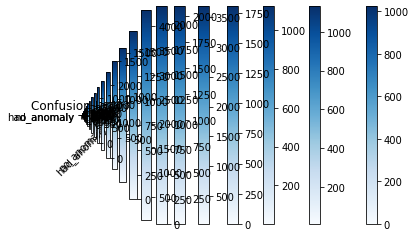

In [ ]:
import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import holidays
import json
import copy
import numpy as np
import torch
import random
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
seed=42
torch.backends.cudnn.determinestic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
import pandas as pd
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)


def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))
class MCD_AE(nn.Module):

    def __init__(self, n_features, output_length, batch_size):
        super(MCD_AE, self).__init__()

        self.batch_size = batch_size  # user-defined

        self.hidden_size_1 = 128
        self.hidden_size_2 = 32
        self.stacked_layers = 2
        self.dropout_probability = 0.5  # arbitrary value (the paper suggests that performance is generally stable across all ranges)


        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)

        output, _ = self.lstm1(x, hidden)

        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :]  # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state

    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

###Prepare Labels
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

# %%
os.makedirs('csv', exist_ok=True)

# %%
selected_columns = ['index', 'name',  'value']



df_label = pd.read_csv(CSV_URL)

#name='F-7'
MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']






SMAP=pd.Series(SMAP)
MSL=pd.Series(MSL)

#pdb.set_trace()
avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=55
training_truth_df=pd.DataFrame()

for name in MSL:

        label_row = df_label[df_label.chan_id == name]
       # pdb.set_trace()

        labels = label_row.anomaly_sequences[im]
        labels = eval(labels)

        true_indices_grouped = [list(range(e[0], e[1] + 1)) for e in labels]
        true_indices_flat = set([i for group in true_indices_grouped for i in group])

        appended_data = []

        labels = true_indices_flat

    # for i in range(len(labels)):
    #    anom=labels[i]
    # start=anom[0]
    # end=anom[1]

        index = list(labels)

    # timestamp = index * 86400 + 1022819200

        anomalies = pd.DataFrame({'value': 1, 'index': index})
    #     appended_data.append(anomalies)

        label_data = anomalies

    # label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
    # label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data['name'] = name
    # label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
    # label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)


        #label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        #label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        #label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        #label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'name']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        #plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 10

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)

        #sns.displot(data=y_test,  kind="hist", bins=100, aspect=1.5)
      #  plt.show()
       # pdb.set_trace()

        #f = Fitter(y_train,
         #          distributions=['gamma',
          #                        'lognorm',
           #                       "beta",
            #                      "burr",
             #                     "norm",'cauchy', 'chi2', 'expon', 'exponpow', 'powerlaw', 'rayleigh', 'uniform'])
        #f.fit()
        #f.summary()
        #pdb.set_trace()
        n_features = scaled_array.shape[-1]
        sequence_length = 10
        output_length = 1

        batch_size = 64
        n_epochs = 10
        learning_rate = 0.01

        bayesian_lstm = MCD_AE(n_features=n_features,
                                     output_length=output_length,
                                     batch_size=batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)
        bayesian_lstm.train()

        for e in range(1, n_epochs + 1):
            for b in range(0, len(X_train), batch_size):
                features = X_train[b:b + batch_size, :, :]
                target = y_train[b:b + batch_size]

                X_batch = torch.tensor(features, dtype=torch.float32)
                y_batch = torch.tensor(target, dtype=torch.float32)
               # pdb.set_trace()

                output = bayesian_lstm(X_batch)
                loss = criterion(output.view(-1), y_batch)


                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if e % 10 == 0:
                print('epoch', e, 'loss: ', loss.item())
                offset = sequence_length

        training_df = pd.DataFrame()
       # training_df['date'] = resample_df['date'].iloc[offset:n_train + offset:1]
        training_df['index'] = resample_df['index'].iloc[offset:n_train + offset:1]
        training_predictions = bayesian_lstm.predict(X_train)


        training_df['value'] = inverse_transform(training_predictions)
        training_df['source'] = 'Training Prediction'


        #training_truth_df['date'] = training_df['date']
        training_truth_df['index'] = training_df['index']
        training_truth_df['value'] = resample_df['value'].iloc[
                                     offset:n_train + offset:1]
        training_truth_df['source'] = 'True Values'

        testing_df = pd.DataFrame()
        #testing_df['date'] = resample_df_test['date'].iloc[offset:n_test + offset:1]
        testing_df['index'] = resample_df_test['index'].iloc[offset:n_test + offset:1]

        testing_predictions = bayesian_lstm.predict(X_test)

        testing_df['value'] = inverse_transform(testing_predictions)
        testing_df['source'] = 'Test Prediction'

        testing_truth_df = pd.DataFrame()
        #testing_truth_df['date'] = testing_df['date']
        testing_truth_df['index'] = testing_df['index']

        testing_truth_df['value'] = resample_df_test['value'].iloc[offset:n_test + offset:1]
        testing_truth_df['source'] = 'True Values'


        evaluation = pd.concat([training_df,
                                testing_df,
                                training_truth_df,
                                testing_truth_df
                                ], axis=0)

        fig = px.line(evaluation,
                             x="index",
                              y="value",
                              color="source")
        #fig.show()

        n_experiments = 2
        test_uncertainty_df = pd.DataFrame()
        #test_uncertainty_df['date'] = testing_df['date']
        test_uncertainty_df['index'] = testing_df['index']

        for i in range(n_experiments):
            experiment_predictions = bayesian_lstm.predict(X_test)

            test_uncertainty_df['value_{}'.format(i)] = inverse_transform(experiment_predictions)

        log_energy_consumption_df = test_uncertainty_df.filter(like='value', axis=1)
        test_uncertainty_df['value_mean'] = log_energy_consumption_df.mean(axis=1)
        test_uncertainty_df['value_std'] = log_energy_consumption_df.std(axis=1)


        test_uncertainty1 = test_uncertainty_df['value_mean']

        #########################Adaptive Smoothing

        #   pdb.set_trace()
        Threshold = 10
        gamma = 0.1
        betta = 0.1
        test_uncertainty2 = []
        ###########
        for jj in range(len(test_uncertainty1) - 2):
            test_uncertaintyy = (1 / (1 + gamma + betta)) * (
                        test_uncertainty1.iloc[jj] + gamma * test_uncertainty1.iloc[jj + 1] + betta *
                        test_uncertainty1.iloc[jj + 2])
            test_uncertainty2.append(test_uncertaintyy)
        test_uncertainty2 = pd.DataFrame(test_uncertainty2)

        test_uncertainty2.columns = ["value_mean"]


        test_uncertainty_df["value_mean"] = test_uncertainty2["value_mean"]

        ########################################################


        test_uncertainty_df = test_uncertainty_df[['index',  'value_mean', 'value_std']]
        test_uncertainty_df['lower_bound'] = test_uncertainty_df['value_mean'] - 3* test_uncertainty_df['value_std']
        test_uncertainty_df['upper_bound'] = test_uncertainty_df['value_mean'] + 3* test_uncertainty_df['value_std']
        import plotly.graph_objects as go

        test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
        # test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2016-05-01', '2016-05-09')]
        truth_uncertainty_plot_df = testing_truth_df.copy(deep=True)
        # truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_truth_df['date'].between('2016-05-01', '2016-05-09')]

        upper_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['upper_bound'],
          mode='lines',
         fill=None,
         name='99% Upper Confidence Bound'
         )
        lower_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['lower_bound'],
          mode='lines',
          fill='tonexty',
         name= '99% Lower Confidence Bound',
         fillcolor='rgba(255, 211, 0, 0.1)',
         )
        real_trace = go.Scatter(
            x=truth_uncertainty_plot_df['index'],
            y=truth_uncertainty_plot_df['value'],
            mode='lines',
            fill=None,
            name='Real Values'
        )

        labels = go.Scatter(
           x=label_data['index'],
          y=label_data['value'],
         mode='lines',
         fill='tonexty' ,
         name='labels'
         )
        data = [upper_trace, lower_trace, real_trace]

        fig = go.Figure(data=data)
        fig.update_layout(title='Uncertainty MCDropout Test Data',
                            xaxis_title='index',
                            yaxis_title='value',
         legend_font_size=14,
                          )
        #fig.show()
        bounds_df = pd.DataFrame()

        # Using 99% confidence bounds
        bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
        bounds_df['prediction'] = test_uncertainty_plot_df['value_mean']
        bounds_df['real_value'] = truth_uncertainty_plot_df['value']
        bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

        bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                                  (bounds_df['real_value'] <= bounds_df['upper_bound']))

        print("Proportion of points contained within 99% confidence interval:",
              bounds_df['contained'].mean())
        predictedanomaly = bounds_df.index[~bounds_df['contained']]
        predictedanomaly = bounds_df.index[~bounds_df['contained']]

        N = 15
        newarr = []


        for i in range(len(predictedanomaly) - N):
            if (predictedanomaly[i] + 1 == predictedanomaly[i + 1] and predictedanomaly[i + 1] + 1 == predictedanomaly[
               i + 2] and predictedanomaly[i+3]+1==predictedanomaly[i+4] and predictedanomaly[i+4]+1==predictedanomaly[i+5]
                and  predictedanomaly[i+5]+1==predictedanomaly[i+6] and predictedanomaly[i+6]+1==predictedanomaly[i+7]
                and predictedanomaly[i+7]+1==predictedanomaly[i+8]
                and predictedanomaly[i+8]+1==predictedanomaly[i+9]
                and predictedanomaly[i+9]+1==predictedanomaly[i+10]
                and predictedanomaly[i+10]+1==predictedanomaly[i+11]
                and predictedanomaly[i+11]+1==predictedanomaly[i+12]
                and predictedanomaly[i + 12] + 1 == predictedanomaly[i + 13]
                and predictedanomaly[i + 13] + 1 == predictedanomaly[i + 14]
                and predictedanomaly[i + 14] + 1 == predictedanomaly[i + 15]):

                newarr.append(predictedanomaly[i])
        #        newarr.append(predictedanomaly[i + 1])
         #       newarr.append(predictedanomaly[i + 2])


        predicteddanomaly = list(set(newarr))




        realanomaly = label_data['index']

        predicter=list(range(len(test_uncertainty2)))

        a1 = pd.DataFrame(index=range(len(test_uncertainty2)),columns=range(2))
        a1.columns=['index','value']

        a2 = pd.DataFrame(index=range(len(test_uncertainty2)), columns=range(2))
        a2.columns = ['index','value']




        for i in range(len(predicter)):
            if i in predicteddanomaly:
                a1.iloc[i,1]=1
            else:
                a1.iloc[i,1]=0

        for i in range(len(predicter)):
            if i in realanomaly:
                a2.iloc[i,1] = 1
            else:
                a2.iloc[i, 1] = 0



        y_real=a2.value
        y_real=y_real.astype(int)
        y_predi=a1.value
        y_predi=y_predi.astype(int)


        cm = confusion_matrix(y_true=y_real, y_pred=y_predi)
        cm_plot_labels = ['no_anomaly', 'had_anomaly']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

        # tp = len([np.where(predicteddanomaly == x)[0] for x in realanomaly])
        #fp = len(predicteddanomaly) - tp
        #fn = 0
        #tn = len(truth_uncertainty_plot_df) - tp - fp - fn

        tp=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tn=cm[1][1]

        precision1 = tp / (tp + fp)
        recall1 = tp / (tp + fn)
        Accuracy1 = (tp + tn) / len(truth_uncertainty_plot_df)
        F11 = 2 / ((1 / precision1) + (1 / recall1))
        print('precision', precision1, 'Signal', name)
        print('recall', recall1, 'Signal', name)
        print('Accuracy', Accuracy1, 'Signal', name)
        print('F1', F11, 'Signal', name)
        precision.append(precision1)
        F1.append(F11)
        Accuracy.append(Accuracy1)
        recall.append(recall1)

        im=im+1

        #matched_indices = list(i_anom_predicted & true_indices_flat)


recall_final=mean(recall)
precision_final=mean(precision)
F1_final=mean(F1)
Accuracy_final=mean(Accuracy)


print('precision_final', precision_final)
print('recall_final', recall_final)
print('Accuracy_final',Accuracy_final)
print('F1_final', F1_final)

        #matched_indices = list(i_anom_predicted & true_indices_flat)


#cm = confusion_matrix(y_true=test_labels, y_pred=predicteddanomaly)

################################################################################

# %%

## New Test Bayesian LSTM AE


In [ ]:
from statistics import mean
import math
F1y = [item for item in F1 if not(math.isnan(item)) == True]
F1t = [0 if math.isnan(x) else x for x in F1]
F1_final1=mean(F1t)
F1_final2=mean(F1y)
Recally = [item for item in recall if not(math.isnan(item)) == True]
Recallt = [0 if math.isnan(x) else x for x in recall]
Recall_final=mean(Recallt)
Precisiont = [item for item in precision if not(math.isnan(item)) == True]
Precision_final=mean(Precisiont)
print('Precision_final', Precision_final)
print('Recall_final_', Recall_final)

print('F1_final_smap',F1_final1)


Precision_final 0.5876184028812488
Recall_final_ 0.8486361409569838
F1_final_smap 0.6451897425232336


In [ ]:
import io
import os
import urllib.request
import zipfile
import datetime
import pdb
import holidays
import json
import copy
import numpy as np
import torch
import random
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import seaborn as sns
from datetime import datetime
import pandas as pd
DATA_URL = 'https://s3-us-west-2.amazonaws.com/telemanom/data.zip'
from statistics import mean
from sklearn.metrics import confusion_matrix
import itertools
seed=42
torch.backends.cudnn.determinestic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
if not os.path.exists('data'):
    response = urllib.request.urlopen(DATA_URL)
    bytes_io = io.BytesIO(response.read())

    with zipfile.ZipFile(bytes_io) as zf:
        zf.extractall()
#from data import load_signal
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

train_signals = os.listdir('data/train')
test_signals = os.listdir('data/test')
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       
  
def build_df(data, start=0):
#
    index = np.array(range(start, start + len(data)))
    timestamp = index * 86400 + 1022819200



    return pd.DataFrame({'timestamp': timestamp.astype(int), 'value': data[:, 0], 'index': index.astype(int)})


def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)


def inverse_transform(y):
    return target_scaler.inverse_transform(y.reshape(-1, 1))
class MCD_AE(nn.Module):

    def __init__(self, n_features, output_length, batch_size):
        super(MCD_AE, self).__init__()

        self.batch_size = batch_size  # user-defined

        self.hidden_size_1 = 80
        self.hidden_size_2 = 32
        self.hidden_size_3= 16
        self.hidden_size_4 = 32
        self.stacked_layers = 2
        self.dropout_probability = 0.5  # arbitrary value (the paper suggests that performance is generally stable across all ranges)


        self.lstm1 = nn.LSTM(n_features,
                             self.hidden_size_1,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm3 = nn.LSTM(self.hidden_size_2,
                             self.hidden_size_3,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm4 = nn.LSTM(self.hidden_size_3,
                             self.hidden_size_4,
                             num_layers=self.stacked_layers,
                             batch_first=True)

        self.fc = nn.Linear(self.hidden_size_4, output_length)
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)

        output, _ = self.lstm1(x, hidden)

        #output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        state = self.init_hidden3(batch_size)
        output, state = self.lstm3(output, state)
        state = self.init_hidden4(batch_size)
        output, state = self.lstm4(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :]  # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred

    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state

    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state
    def init_hidden3(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_3))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_3))
        return hidden_state, cell_state
    def init_hidden4(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_4))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_4))
        return hidden_state, cell_state
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()
###Prepare Labels
CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

# %%
os.makedirs('csv', exist_ok=True)

# %%
selected_columns = ['index', 'name',  'value']



df_label = pd.read_csv(CSV_URL)

#name='F-7'
MSL=df_label[df_label.spacecraft=='MSL']['chan_id']
SMAP=df_label[df_label.spacecraft=='SMAP']['chan_id']






SMAP=pd.Series(SMAP)
MSL=pd.Series(MSL)

#pdb.set_trace()
avg=[]
train_signals=SMAP
precision=[]
recall=[]
Accuracy=[]
F1=[]
im=55
training_truth_df=pd.DataFrame()

for name in MSL:

        label_row = df_label[df_label.chan_id == name]
    # pdb.set_trace()

        labels = label_row.anomaly_sequences[im]
        labels = eval(labels)

        true_indices_grouped = [list(range(e[0], e[1] + 1)) for e in labels]
        true_indices_flat = set([i for group in true_indices_grouped for i in group])

        appended_data = []

        labels = true_indices_flat

    # for i in range(len(labels)):
    #    anom=labels[i]
    # start=anom[0]
    # end=anom[1]

        index = list(labels)

    # timestamp = index * 86400 + 1022819200

        anomalies = pd.DataFrame({'value': 1, 'index': index})
    #     appended_data.append(anomalies)

        label_data = anomalies

    # label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
    # label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data['name'] = name
    # label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
    # label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)


        #label_data ['date'] = pd.to_datetime(label_data ['timestamp'], unit='s')
        #label_data ['month'] = label_data ['date'].dt.month.astype(int)
        label_data ['name'] = name
        #label_data ['day_of_week'] = label_data ['date'].dt.dayofweek.astype(int)
        #label_data ['hour_of_day'] = label_data ['date'].dt.hour.astype(int)
        label_data  = label_data [selected_columns]
        #label_data .to_csv('csv/' + name + '.csv', index=False)


        signal=name
        train_np = np.load('data/train/' + signal + '.npy')
        test_np = np.load('data/test/' + signal + '.npy')


        data = build_df(np.concatenate([train_np, test_np]))
        data['date'] = pd.to_datetime(data['timestamp'], unit='s')
        data['month'] = data['date'].dt.month.astype(int)
        data['name'] = name
        data['index'] = data['index'].astype(int)
        data['day_of_week'] = data['date'].dt.dayofweek.astype(int)
        data['hour_of_day'] = data['date'].dt.hour.astype(int)
        data = data[selected_columns]
        _ , validation = train_test_split(
            data,
            test_size=0.15
        )

        val_dataset=validation

        val=val_dataset


        #val['index'] = val['index'].astype(int)
        #val['date'] = pd.to_datetime(val['timestamp'], unit='s')
        #val['month'] = val['date'].dt.month.astype(int)
        #val['day_of_month'] = val['date'].dt.day.astype(int)
        #val['name'] = name
        #val['day_of_week'] = val['date'].dt.dayofweek.astype(int)
        #val['hour_of_day'] = val['date'].dt.hour.astype(int)
        #val['index'] = val['index'].astype(int)
        #val = val[selected_columns]

        train = build_df(train_np)
        train['date'] = pd.to_datetime(train['timestamp'], unit='s')
        train['month'] = train['date'].dt.month.astype(int)
        train['day_of_month'] = train['date'].dt.day.astype(int)
        train['name'] = name
        train['day_of_week'] = train['date'].dt.dayofweek.astype(int)
        train['hour_of_day'] = train['date'].dt.hour.astype(int)
        train['index'] = train['index'].astype(int)
        train = train[selected_columns]
        # train.to_csv('csv/' + name + '.csv', index=False)
        # train.to_csv('csv/' + name + '-train.csv', index=False)


        test = build_df(test_np, start=len(train))
        test['date'] = pd.to_datetime(test['timestamp'], unit='s')
        test['month'] = test['date'].dt.month.astype(int)
        test['name'] = name
        test['day_of_week'] = test['date'].dt.dayofweek.astype(int)
        test['hour_of_day'] = test['date'].dt.hour.astype(int)
        test['index'] = test['index'].astype(int)
        test = test[selected_columns]
        # test.to_csv('csv/' + name + '.csv', index=False)
        # test.to_csv('csv/' + name + '-train.csv', index=False)
        # test.to_csv('csv/' + name + '-test.csv', index=False)

        datetime_columns = ['index', 'name']
        target_column = 'value'

        feature_columns = datetime_columns + ['value']

        resample_df = train[feature_columns]
        resample_df_test = test[feature_columns]
        resample_df_val=val[feature_columns]
        #print(resample_df)

        plot_length = 1000000
        plot_df = resample_df.copy(deep=True).iloc[:plot_length]
        #plot_df['weekday'] = plot_df['date'].dt.day_name()

        n_train = len(train_np)
        n_test = len(test_np)

        features = ['index', 'value']
        feature_array = resample_df[features].values
        feature_array_test = resample_df_test[features].values
        feature_array_val = resample_df_val[features].values
        # Fit Scaler only on Training features
        feature_scaler = MinMaxScaler()
        feature_scaler.fit(feature_array[:n_train])
        # Fit Scaler only on Training target values
        #feature_scaler.fit(feature_array_test[:n_test])

        target_scaler = MinMaxScaler()
        target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

        # Transfom on both Training and Test data
        scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                                    columns=features)

        scaled_array_test = pd.DataFrame(feature_scaler.transform(feature_array_test),
                                         columns=features)
        scaled_array_val = pd.DataFrame(feature_scaler.transform(feature_array_val),
                                         columns=features)

        sequence_length = 10

        X_train, y_train = create_sliding_window(scaled_array,
                                                 sequence_length)

        X_test, y_test = create_sliding_window(scaled_array_test,
                                               sequence_length)
        X_val, y_val = create_sliding_window(scaled_array_val,
                                               sequence_length)

        #sns.displot(data=y_test,  kind="hist", bins=100, aspect=1.5)
      #  plt.show()
       # pdb.set_trace()

        #f = Fitter(y_train,
         #          distributions=['gamma',
          #                        'lognorm',
           #                       "beta",
            #                      "burr",
             #                     "norm",'cauchy', 'chi2', 'expon', 'exponpow', 'powerlaw', 'rayleigh', 'uniform'])
        #f.fit()
        #f.summary()
        #pdb.set_trace()
        n_features = scaled_array.shape[-1]
        sequence_length = 10
        output_length = 1

        batch_size = 64
        n_epochs = 10
        learning_rate = 0.01

        bayesian_lstm = MCD_AE(n_features=n_features,
                                     output_length=output_length,
                                     batch_size=batch_size)

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)
        bayesian_lstm.train()

        for e in range(1, n_epochs + 1):
            for b in range(0, len(X_train), batch_size):
                features = X_train[b:b + batch_size, :, :]
                target = y_train[b:b + batch_size]

                X_batch = torch.tensor(features, dtype=torch.float32)
                y_batch = torch.tensor(target, dtype=torch.float32)
               # pdb.set_trace()

                output = bayesian_lstm(X_batch)
                loss = criterion(output.view(-1), y_batch)


                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            if e % 10 == 0:
                print('epoch', e, 'loss: ', loss.item())
                offset = sequence_length

        training_df = pd.DataFrame()
       # training_df['date'] = resample_df['date'].iloc[offset:n_train + offset:1]
        training_df['index'] = resample_df['index'].iloc[offset:n_train + offset:1]
        training_predictions = bayesian_lstm.predict(X_train)


        training_df['value'] = inverse_transform(training_predictions)
        training_df['source'] = 'Training Prediction'


        #training_truth_df['date'] = training_df['date']
        training_truth_df['index'] = training_df['index']
        training_truth_df['value'] = resample_df['value'].iloc[
                                     offset:n_train + offset:1]
        training_truth_df['source'] = 'True Values'

        testing_df = pd.DataFrame()
        #testing_df['date'] = resample_df_test['date'].iloc[offset:n_test + offset:1]
        testing_df['index'] = resample_df_test['index'].iloc[offset:n_test + offset:1]

        testing_predictions = bayesian_lstm.predict(X_test)

        testing_df['value'] = inverse_transform(testing_predictions)
        testing_df['source'] = 'Test Prediction'

        testing_truth_df = pd.DataFrame()
        #testing_truth_df['date'] = testing_df['date']
        testing_truth_df['index'] = testing_df['index']

        testing_truth_df['value'] = resample_df_test['value'].iloc[offset:n_test + offset:1]
        testing_truth_df['source'] = 'True Values'


        evaluation = pd.concat([training_df,
                                testing_df,
                                training_truth_df,
                                testing_truth_df
                                ], axis=0)

        fig = px.line(evaluation,
                             x="index",
                              y="value",
                              color="source")
        #fig.show()

        n_experiments = 2
        test_uncertainty_df = pd.DataFrame()
        #test_uncertainty_df['date'] = testing_df['date']
        test_uncertainty_df['index'] = testing_df['index']

        for i in range(n_experiments):
            experiment_predictions = bayesian_lstm.predict(X_test)

            test_uncertainty_df['value_{}'.format(i)] = inverse_transform(experiment_predictions)

        log_energy_consumption_df = test_uncertainty_df.filter(like='value', axis=1)
        test_uncertainty_df['value_mean'] = log_energy_consumption_df.mean(axis=1)
        test_uncertainty_df['value_std'] = log_energy_consumption_df.std(axis=1)


        test_uncertainty1 = test_uncertainty_df['value_mean']

        #########################Adaptive Smoothing

        #   pdb.set_trace()
        Threshold = 10
        gamma = 0.1
        betta = 0.1
        test_uncertainty2 = []
        ###########
        for jj in range(len(test_uncertainty1) - 2):
            test_uncertaintyy = (1 / (1 + gamma + betta)) * (
                        test_uncertainty1.iloc[jj] + gamma * test_uncertainty1.iloc[jj + 1] + betta *
                        test_uncertainty1.iloc[jj + 2])
            test_uncertainty2.append(test_uncertaintyy)
        test_uncertainty2 = pd.DataFrame(test_uncertainty2)

        test_uncertainty2.columns = ["value_mean"]


        test_uncertainty_df["value_mean"] = test_uncertainty2["value_mean"]

        ########################################################


        test_uncertainty_df = test_uncertainty_df[['index',  'value_mean', 'value_std']]
        test_uncertainty_df['lower_bound'] = test_uncertainty_df['value_mean'] - 5* test_uncertainty_df['value_std']
        test_uncertainty_df['upper_bound'] = test_uncertainty_df['value_mean'] + 5 * test_uncertainty_df['value_std']
        import plotly.graph_objects as go

        test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
        # test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2016-05-01', '2016-05-09')]
        truth_uncertainty_plot_df = testing_truth_df.copy(deep=True)
        # truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_truth_df['date'].between('2016-05-01', '2016-05-09')]

        upper_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['upper_bound'],
          mode='lines',
         fill=None,
         name='99% Upper Confidence Bound'
         )
        lower_trace = go.Scatter(
            x=test_uncertainty_plot_df['index'],
           y=test_uncertainty_plot_df['lower_bound'],
          mode='lines',
          fill='tonexty',
         name= '99% Lower Confidence Bound',
         fillcolor='rgba(255, 211, 0, 0.1)',
         )
        real_trace = go.Scatter(
            x=truth_uncertainty_plot_df['index'],
            y=truth_uncertainty_plot_df['value'],
            mode='lines',
            fill=None,
            name='Real Values'
        )

        labels = go.Scatter(
           x=label_data['index'],
          y=label_data['value'],
         mode='lines',
         fill='tonexty' ,
         name='labels'
         )
        data = [upper_trace, lower_trace, real_trace]

        fig = go.Figure(data=data)
        fig.update_layout(title='Uncertainty MCDropout Test Data',
                            xaxis_title='index',
                            yaxis_title='value',
         legend_font_size=14,
                          )
        #fig.show()
        bounds_df = pd.DataFrame()

        # Using 99% confidence bounds
        bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
        bounds_df['prediction'] = test_uncertainty_plot_df['value_mean']
        bounds_df['real_value'] = truth_uncertainty_plot_df['value']
        bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

        bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                                  (bounds_df['real_value'] <= bounds_df['upper_bound']))

        print("Proportion of points contained within 99% confidence interval:",
              bounds_df['contained'].mean())
        predictedanomaly = bounds_df.index[~bounds_df['contained']]






        realanomaly = label_data['index']

        predicter=list(range(len(test_uncertainty2)))

        a1 = pd.DataFrame(index=range(len(test_uncertainty2)),columns=range(2))
        a1.columns=['index','value']

        a2 = pd.DataFrame(index=range(len(test_uncertainty2)), columns=range(2))
        a2.columns = ['index','value']




        for i in range(len(predicter)):
            if i in predictedanomaly:
                a1.iloc[i,1]=1
            else:
                a1.iloc[i,1]=0

        for i in range(len(predicter)):
            if i in realanomaly:
                a2.iloc[i,1] = 1
            else:
                a2.iloc[i, 1] = 0

        y_real=a2.value
        y_real=y_real.astype(int)
        y_predi=a1.value
        y_predi=y_predi.astype(int)


        cm = confusion_matrix(y_true=y_real, y_pred=y_predi)
        cm_plot_labels = ['no_anomaly', 'had_anomaly']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

        # tp = len([np.where(predicteddanomaly == x)[0] for x in realanomaly])
        #fp = len(predicteddanomaly) - tp
        #fn = 0
        #tn = len(truth_uncertainty_plot_df) - tp - fp - fn

        tp=cm[0][0]
        fp=cm[0][1]
        fn=cm[1][0]
        tn=cm[1][1]

        precision1 = tp / (tp + fp)
        recall1 = tp / (tp + fn)
        Accuracy1 = (tp + tn) / len(truth_uncertainty_plot_df)
        F11 = 2 / ((1 / precision1) + (1 / recall1))
        print('precision', precision1, 'Signal', name)
        print('recall', recall1, 'Signal', name)
        print('Accuracy', Accuracy1, 'Signal', name)
        print('F1', F11, 'Signal', name)
        precision.append(precision1)
        F1.append(F11)
        Accuracy.append(Accuracy1)
        recall.append(recall1)

        im=im+1

        #matched_indices = list(i_anom_predicted & true_indices_flat)


recall_final=mean(recall)
precision_final=mean(precision)
F1_final=mean(F1)
Accuracy_final=mean(Accuracy)
#cm = confusion_matrix(y_true=test_labels, y_pred=predicteddanomaly)

################################################################################

# %%

## New Test Bayesian LSTM AE

print('precision_final', precision_final)
print('recall_final', recall_final)
print('Accuracy_final',Accuracy_final)
print('F1_final', F1_final)

epoch 10 loss:  1.6555158310893603e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.443845022069642
precision 0.4040948275862069 Signal M-6
recall 0.819672131147541 Signal M-6
Accuracy 0.3756743501716528 Signal M-6
F1 0.5413208228076507 Signal M-6
epoch 10 loss:  0.0406455360352993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.11601235112483459
precision 0.21441281138790036 Signal M-1
recall 0.8827838827838828 Signal M-1
Accuracy 0.5955006616674019 Signal M-1
F1 0.34502505368647096 Signal M-1
epoch 10 loss:  0.14186452329158783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.1310101455668284
precision 0.05338078291814947 Signal M-2
recall 0.19543973941368079 Signal M-2
Accuracy 0.42082046757829733 Signal M-2
F1 0.08385744234800838 Signal M-2
epoch 10 loss:  5.3213284445519093e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9124931205283434
precision 0.9185144124168514 Signal S-2
recall 0.9934052757793765 Signal S-2
Accuracy 0.9119427627958173 Signal S-2
F1 0.9544930875576036 Signal S-2
epoch 10 loss:  0.0053989700973033905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.12315270935960591
precision 0.12220916568742655 Signal P-10
recall 0.9578947368421052 Signal P-10
Accuracy 0.13579638752052545 Signal P-10
F1 0.21676343605776388 Signal P-10
epoch 10 loss:  0.2362346649169922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal T-4
recall 0.0 Signal T-4
Accuracy 0.026733121884911646 Signal T-4
F1 0.0 Signal T-4
epoch 10 loss:  1.2871577581563542e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.9216485507246377
precision 0.9261467889908257 Signal T-5
recall 0.9872860635696822 Signal T-5
Accuracy 0.9144021739130435 Signal T-5
F1 0.9557396449704143 Signal T-5
epoch 10 loss:  0.00693937623873353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.021015067406819986
precision 0.01970123403334055 Signal F-7
recall 0.7844827586206896 Signal F-7
Accuracy 0.09694686756542427 Signal F-7
F1 0.03843717001055966 Signal F-7
epoch 10 loss:  0.041444338858127594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5819555975436939
precision 0.5756437768240343 Signal M-3
recall 0.8639291465378421 Signal M-3
Accuracy 0.545583372697213 Signal M-3
F1 0.690920798454604 Signal M-3
epoch 10 loss:  0.06023547425866127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.49556213017751477
precision 0.48225352112676056 Signal M-4
recall 0.8433497536945813 Signal M-4
Accuracy 0.46745562130177515 Signal M-4
F1 0.6136200716845879 Signal M-4
epoch 10 loss:  0.062252409756183624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.13911905800261665
precision 0.13969849246231156 Signal M-5
recall 0.8449848024316109 Signal M-5
Accuracy 0.23026602703881377 Signal M-5
F1 0.23975851660198363 Signal M-5
epoch 10 loss:  0.00424558948725462


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.11384399156711174
precision 0.11229188806234502 Signal P-15
recall 0.9491017964071856 Signal P-15
Accuracy 0.11278988053408293 Signal P-15
F1 0.2008235666772252 Signal P-15
epoch 10 loss:  0.0064310417510569096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0417036379769299
precision 0.04793814432989691 Signal C-1
recall 0.8942307692307693 Signal C-1
Accuracy 0.17480035492457852 Signal C-1
F1 0.09099804305283758 Signal C-1
epoch 10 loss:  7.976506708473607e-07


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.21117099461048505
precision 0.16246056782334384 Signal C-2
recall 0.7006802721088435 Signal C-2
Accuracy 0.15384615384615385 Signal C-2
F1 0.26376440460947503 Signal C-2
epoch 10 loss:  0.16624926030635834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4177685950413223
precision 0.4222899434044406 Signal T-12
recall 0.9500489715964741 Signal T-12
Accuracy 0.4297520661157025 Signal T-12
F1 0.5846895720313441 Signal T-12
epoch 10 loss:  0.15152139961719513


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.4334710743801653
precision 0.46860572483841184 Signal T-13
recall 0.9584513692162417 Signal T-13
Accuracy 0.5053719008264462 Signal T-13
F1 0.6294573643410852 Signal T-13
epoch 10 loss:  0.030667206272482872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.004103165298944901
precision 0.0035938903863432167 Signal F-4
recall 0.5 Signal F-4
Accuracy 0.020808909730363423 Signal F-4
F1 0.007136485280999108 Signal F-4
epoch 10 loss:  6.844357267254964e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.1955521472392638
precision 0.19074221867517957 Signal F-5
recall 0.9251612903225807 Signal F-5
Accuracy 0.20705521472392638 Signal F-5
F1 0.3162770180855756 Signal F-5
epoch 10 loss:  5.996279917042102e-09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.8531548757170172
precision 0.849017147636972 Signal D-14
recall 0.9058456046407853 Signal D-14
Accuracy 0.7804971319311663 Signal D-14
F1 0.8765112262521588 Signal D-14
epoch 10 loss:  0.013118118979036808


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.6519337016574586
precision 0.6522633744855967 Signal T-9
recall 0.883008356545961 Signal T-9
Accuracy 0.6095764272559853 Signal T-9
F1 0.7502958579881656 Signal T-9
epoch 10 loss:  0.008642669767141342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:594: RuntimeWarning:

divide by zero encountered in double_scalars



precision 0.0 Signal P-14
recall 0.0 Signal P-14
Accuracy 0.02807881773399015 Signal P-14
F1 0.0 Signal P-14
epoch 10 loss:  0.00014663091860711575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.781974817760106
precision 0.7900355871886121 Signal T-8
recall 0.9327731092436975 Signal T-8
Accuracy 0.7501656726308814 Signal T-8
F1 0.8554913294797688 Signal T-8
epoch 10 loss:  0.007869536988437176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5134751773049645
precision 0.5153262518968134 Signal P-11
recall 0.932967032967033 Signal P-11
Accuracy 0.51177304964539 Signal P-11
F1 0.6639296187683285 Signal P-11
epoch 10 loss:  0.16263936460018158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5623836126629422
precision 0.532890365448505 Signal D-15
recall 0.6584564860426929 Signal D-15
Accuracy 0.4781191806331471 Signal D-15
F1 0.5890561880279104 Signal D-15
epoch 10 loss:  0.03635784611105919


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.11829436038514443
precision 0.1544502617801047 Signal D-16
recall 0.8805970149253731 Signal D-16
Accuracy 0.3920220082530949 Signal D-16
F1 0.26280623608017817 Signal D-16
epoch 10 loss:  2.294266778335441e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.5549860205032618
precision 0.5584924131179638 Signal M-7
recall 0.9500416319733556 Signal M-7
Accuracy 0.5507921714818267 Signal M-7
F1 0.7034525277435265 Signal M-7
epoch 10 loss:  0.013167050667107105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:478: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Proportion of points contained within 99% confidence interval: 0.005248284214775939
precision 0.006707946336429308 Signal F-8
recall 0.5652173913043478 Signal F-8
Accuracy 0.21800565199838515 Signal F-8
F1 0.013258541560428352 Signal F-8
precision_final 0.3453022792164728
recall_final 0.7688818291609754
Accuracy_final 0.3942435706074073
F1_final 0.42547718607995016


In [ ]:

from statistics import mean
import math
F1y = [item for item in F1 if not(math.isnan(item)) == True]
F1t = [0 if math.isnan(x) else x for x in F1]
F1_final1=mean(F1t)
F1_final2=mean(F1y)
Recall_final=mean(Recall)
Precisiont = [item for item in Precision if not(math.isnan(item)) == True]
Precision_final=mean(Precisiont)
print('Precision_final_smap_tadgan', Precision_final)
print('Recall_final_smap_tadgan', Recall_final)

print('F1_final_smap_tadgan',F1_final1)
print('F1_final_smap_tadgan',F1_final2)
